In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Create lagged dataset
def create_lagged_dataset(dataset, lag_dict, target_var):
    lagged_dataset = dataset.copy()
    columns_list = list(lagged_dataset.columns)
    data_join = {}
    for column in columns_list:
        if column == 'date':
            continue
        col_lag = lag_dict[column]
        if column == target_var:
            data_join[column] = lagged_dataset[column]
        for n in range(1,col_lag+1):
            data_join[F'{column}_L{n}'] = lagged_dataset[column].shift(n)
    lagged_dataset = pd.concat(data_join.values(), axis=1, ignore_index = True)
    lagged_dataset.columns = data_join.keys()
    return lagged_dataset.dropna() # dropping of NaN values so that regression can be easily done

# Generate Stepped Dataset for Training
## Steps is the number of weeks ahead that we are forecasting, e.g. step=2 is 2 weeks ahead.
## Note step=1 results in no change to dataset, i.e. use generated lagged variables to forecast current. 
def create_stepped_dataset(dataset, step, target_var):
    shifted_dataset = dataset.copy()
    y = shifted_dataset[[target_var]].shift(-step+1)
    if step != 1:
        X = shifted_dataset.iloc[:-step+1, :] # remove the last few rows
    else:
        X = shifted_dataset
    return X.drop(target_var, axis = 1), y.dropna()
## So now target variable (y variable for exploration) is shifted back by 2 weeks. i.e., taking the y-value from 2 weeks later
## and setting it to the current index. So linear regression of y+2 with the current X values. X will have
## a smaller dataset with the last 2 time points removed because of the shift. 

def generate_next_date(list_of_dates, date):
    return list_of_dates[list_of_dates > date].min()

def process_factor_model(X_factor, y_factor, train_end, window_length = 120):
    X_train = X_factor.iloc[train_end-window_length:train_end]
    X_test = X_factor.iloc[train_end:train_end+1]

    y_train = y_factor.loc[X_train.index]
    y_test = y_factor.loc[X_test.index]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [2]:
us_optimal_lags = dict({
    'infl_rate_diff':14,
    'cons_conf':1,
    'gdp_pct_change':14,
    'int_3m':3,
    'ppi_diff':14,
    'unm_rate':1
})

uk_optimal_lags = dict({
    'infl_rate_diff':11,
    'cons_conf':1,
    'gdp_pct_change':11,
    'int_3m':1,
    'ppi_diff':12,
    'unm_rate':4
})

In [3]:
lstm_hyperparams_dict_healthcare_us_monthly = dict(
    {1: dict({
        'units':[96,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.1,0.1,0.1,0.1],
        'activation':['linear','linear','tanh','linear'],
        'lr':0.00209452781254191
    }),
     2: dict({
        'units':[96,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.1,0.2],
        'activation':['linear','linear','tanh'],
        'lr':0.004107775862916715
    }),
     3: dict({
        'units':[96,32,32],
        'optimizer':'Adam',
        'drop_out':[0.2,0.2,0.2],
        'activation':['tanh','tanh','linear'],
        'lr':0.0035406840889284476
    }),
     4: dict({
        'units':[32,32,32],
        'optimizer':'Adam',
        'drop_out':[0.2,0.1,0.2],
        'activation':['tanh','linear','linear'],
        'lr':0.0005842086404315508
    }),
     5: dict({
        'units':[32,32,32],
        'optimizer':'Adam',
        'drop_out':[0.2,0.2,0.1],
        'activation':['sigmoid','tanh','linear'],
        'lr':0.01539768812695964
    }),
     6: dict({
        'units':[64,32,32],
        'optimizer':'Adam',
        'drop_out':[0.2,0.2,0.1],
        'activation':['tanh','linear','linear'],
        'lr':0.001172720778910653
    })}
)

lstm_hyperparams_dict_healthcare_uk_monthly = dict(
    {1: dict({
        'units':[32,32],
        'optimizer':'Adam',
        'drop_out':[0.1,0.1],
        'activation':['linear','tanh'],
        'lr':0.04692773350706299
    }),
     2: dict({
        'units':[32,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.2,0.1,0.1],
        'activation':['linear','linear','tanh','tanh'],
        'lr':0.0027559297251538695
    }),
     3: dict({
        'units':[128,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.1,0.2,0.2,0.1],
        'activation':['tanh','linear','tanh','tanh'],
        'lr':0.0033904359243909243
    }),
     4: dict({
        'units':[96,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.2,0.2,0.1],
        'activation':['tanh','linear','tanh','tanh'],
        'lr':0.0058921140024817105
    }),
     5: dict({
        'units':[64,32,32],
        'optimizer':'Adagrad',
        'drop_out':[0.2,0.1,0.1],
        'activation':['tanh','sigmoid','linear'],
        'lr':0.001379526955364811
    }),
     6: dict({
        'units':[96,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.1,0.2,0.2,0.2],
        'activation':['tanh','linear','tanh','tanh'],
        'lr':0.00023168509056616956
    }),
    7: dict({
        'units':[64,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.2,0.1,0.1],
        'activation':['tanh','tanh','linear','linear'],
        'lr':0.0010137983528640687
    }),
    8: dict({
        'units':[32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.1,0.2],
        'activation':['tanh','tanh','tanh'],
        'lr':0.04818160436963496
    }),
    9: dict({
        'units':[128,32],
        'optimizer':'Adam',
        'drop_out':[0.1,0.1],
        'activation':['tanh','linear'],
        'lr':0.004347669530569911
    }),
    10: dict({
        'units':[128,32],
        'optimizer':'Adam',
        'drop_out':[0.2,0.2],
        'activation':['tanh','tanh'],
        'lr':0.0003758643392217273
    }),
    11: dict({
        'units':[128,32,32,32],
        'optimizer':'Adam',
        'drop_out':[0.1,0.2,0.2,0.1],
        'activation':['tanh','tanh','linear','linear'],
        'lr':0.0005964355656236208
    }),
    12: dict({
        'units':[96,32],
        'optimizer':'Nadam',
        'drop_out':[0.1,0.2],
        'activation':['tanh','linear'],
        'lr':0.0038874392172875733
    }),
    13: dict({
        'units':[64,32,32],
        'optimizer':'Adam',
        'drop_out':[0.1,0.1,0.1],
        'activation':['linear','linear','tanh'],
        'lr':0.0003414596058972786
    }),
    14: dict({
        'units':[128,32,32],
        'optimizer':'Adam',
        'drop_out':[0.2,0.1,0.2],
        'activation':['tanh','tanh','linear'],
        'lr':0.0009549466557181202
    })}
)

lstm_hyperparams_dict_healthcare_us_quarterly = dict(
    {1: dict({
        'units':[32,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.1,0.2,0.1,0.2],
        'activation':['tanh','tanh','tanh','tanh'],
        'lr':0.0004277227509026501
    }),
     2: dict({
        'units':[32,32,32],
        'optimizer':'Adagrad',
        'drop_out':[0.2,0.1,0.2],
        'activation':['tanh','linear','linear'],
        'lr':0.0016339385388774038
    }),
     3: dict({
        'units':[96,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.1,0.2,0.1,0.1],
        'activation':['linear','tanh','tanh','tanh'],
        'lr':0.007599082376541289
    }),
     4: dict({
        'units':[64,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.1,0.1,0.2],
        'activation':['tanh','linear','tanh','linear'],
        'lr':0.0013408442327624412
    })}
)

lstm_hyperparams_dict_healthcare_uk_quarterly = dict(
    {1: dict({
        'units':[32,32,32,32],
        'optimizer':'Adam',
        'drop_out':[0.1,0.2,0.2,0.1],
        'activation':['sigmoid','tanh','tanh','tanh'],
        'lr':0.0014647752917040927
    }),
     2: dict({
        'units':[64,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.1,0.2,0.2],
        'activation':['tanh','linear','linear','tanh'],
        'lr':0.0027559297251538695
    }),
     3: dict({
        'units':[96,32,32,32],
        'optimizer':'Adagrad',
        'drop_out':[0.2,0.2,0.1,0.1],
        'activation':['sigmoid','tanh','tanh','tanh'],
        'lr':0.010813378402855827
    }),
     4: dict({
        'units':[64,32],
        'optimizer':'Nadam',
        'drop_out':[0.1,0.2],
        'activation':['linear','tanh'],
        'lr':0.00971247132967637
    }),
     5: dict({
        'units':[64,32,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.1,0.1,0.1],
        'activation':['tanh','sigmoid','tanh','tanh'],
        'lr':0.0012528157640500648
    }),
     6: dict({
        'units':[128,32,32],
        'optimizer':'Adagrad',
        'drop_out':[0.2,0.1,0.2],
        'activation':['sigmoid','tanh','tanh'],
        'lr':0.03537071368688055
    }),
    7: dict({
        'units':[64,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.1,0.1],
        'activation':['sigmoid','linear','tanh'],
        'lr':0.0006879878591752019
    }),
    8: dict({
        'units':[64,32],
        'optimizer':'Adagrad',
        'drop_out':[0.2,0.2],
        'activation':['sigmoid','sigmoid'],
        'lr':0.022239434498843517
    }),
    9: dict({
        'units':[96,32,32],
        'optimizer':'Nadam',
        'drop_out':[0.1,0.2,0.1],
        'activation':['tanh','tanh','tanh'],
        'lr':0.00029671375213130146
    }),
    10: dict({
        'units':[96,32],
        'optimizer':'Nadam',
        'drop_out':[0.2,0.2],
        'activation':['linear','tanh'],
        'lr':0.0008546915367504593
    }),
    11: dict({
        'units':[32,32,32],
        'optimizer':'Adam',
        'drop_out':[0.1,0.2,0.1],
        'activation':['tanh','linear','tanh'],
        'lr':0.00024260726468585856
    }),
    12: dict({
        'units':[96,32,32],
        'optimizer':'Adagrad',
        'drop_out':[0.2,0.2,0.1],
        'activation':['linear','sigmoid','tanh'],
        'lr':0.02510676487272628
    })}
)

In [23]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
import numpy as np
import math
import keras_tuner as kt
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad, Nadam
from sklearn.decomposition import PCA
import gc

def overall_function(dataset_link, outcome_var, lag_dict, horizon_num, window_length, lstm_hyperparam_dict, period = "monthly"):
    dataset = pd.read_csv(dataset_link)
    dataset['ppi_diff'] = dataset['ppi'].diff()
    dataset['infl_rate_diff'] = dataset['infl_rate'].diff()
    dataset = dataset.dropna(subset=['infl_rate_diff'])
    dataset = dataset.drop(columns=['infl_rate','ppi'])
    dataset['date'] = pd.to_datetime(dataset['date']) # converting to date format
    dataset = dataset.sort_values(by='date')
    dataset = dataset.drop(columns = 'date')
    if period != "monthly":
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset = dataset[dataset['date'].dt.month.isin([3,6,9,12])]

    # Creating Lagged and Stepped Datasets
    X_dataset, y_dataset = create_stepped_dataset(create_lagged_dataset(dataset, lag_dict = lag_dict, target_var = outcome_var), step=horizon_num, target_var = outcome_var)
    
    # Initialising the training end
    train_end = window_length
    
    results = []
    
    ## Implement cross-validation split
    tscv = TimeSeriesSplit(n_splits = 5)
    batch_num = 1
    count = 0
    while train_end < len(X_dataset):
        if count == 24:
            batch_num += 1
            count = 0 # Restart count
        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, window_length=window_length)
        
        # For Adding Results
        df_in_loop = y_test.copy()
        
        ### Model 1: Ridge Regression ###
        ridge_cv = RidgeCV(cv = tscv)
        ridge_cv.fit(X_train, y_train)
    
        ridge_model = Ridge(alpha = ridge_cv.alpha_)
        ridge_model.fit(X_train, y_train)
        
        ridgepred = ridge_model.predict(X_test)
        # Adding Linear Model
        df_in_loop[f'ridge'] = ridgepred
        print('Ridge Done')
        
        ### Model 2: PCA ###
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        X_train_pure = X_train
        X_test_pure = X_test
        
        pca = PCA()
        pca.fit(X_train_pure)
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
          #to explain more than 85% of the variance
        num_components = np.where(cumulative_variance_ratio >= 0.85)[0][0] + 1 
        pca_new = PCA(n_components=num_components)
        X_train_pca = pca_new.fit_transform(X_train_pure)
        X_train_pca = pd.DataFrame(X_train_pca)
        X_train_pca.columns = X_train_pca.columns.astype(str)

        X_test_pca = pca_new.transform(X_test_pure)
        X_test_pca = pd.DataFrame(X_test_pca)
        X_test_pca.columns = X_test_pca.columns.astype(str)
        
        pure_factor_model = LinearRegression()
        pure_factor_model.fit(X_train_pca, y_train)
        y_pred = pure_factor_model.predict(X_test_pca)
        df_in_loop[f'pca'] = y_pred
        print('PCA Done')
        
        # **Free Memory Before LSTM**
        tf.keras.backend.clear_session()
        gc.collect()
        
        ## Model 3: LSTM ###
        X_train_lstm = np.array(X_train).astype(np.float32)
        X_test_lstm = np.array(X_test).astype(np.float32)
        y_train_lstm = np.array(y_train).astype(np.float32)
        
        num_layers = len(lstm_hyperparam_dict[batch_num]['units'])
        print(f'Using LSTM Hyperparameters from batch {batch_num} which has {num_layers} layers!')
        
        # Building LSTM Model
        lstm_model = Sequential()
        for layer_num in range(num_layers):
            is_last_layer =(layer_num == (num_layers - 1))  # Check if it's the last layer
            lstm_model.add(LSTM(
                units=lstm_hyperparam_dict[batch_num]['units'][layer_num], 
                return_sequences=not is_last_layer,  # Only last layer has return_sequences=False
                input_shape=(X_train_lstm.shape[1], 1) if layer_num == 0 else None,  # Define input shape only for the first layer
                activation=lstm_hyperparam_dict[batch_num]['activation'][layer_num]
            ))
            lstm_model.add(Dropout(lstm_hyperparam_dict[batch_num]['drop_out'][layer_num]))
        # Output Layer
        lstm_model.add(Dense(units=1))
        
        # Compilation
        if lstm_hyperparam_dict[batch_num]['optimizer'] == 'Adam':
            lstm_model.compile(
                optimizer=Adam(learning_rate=lstm_hyperparam_dict[batch_num]['lr']),
                loss='mean_squared_error',
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError()
                ]
            )
        elif lstm_hyperparam_dict[batch_num]['optimizer'] == 'Nadam':
            lstm_model.compile(
                optimizer=Nadam(learning_rate=lstm_hyperparam_dict[batch_num]['lr']),
                loss='mean_squared_error',
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError()
                ]
            )
        else:
            lstm_model.compile(
                optimizer=Adagrad(learning_rate=lstm_hyperparam_dict[batch_num]['lr']),
                loss='mean_squared_error',
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError()
                ]
            )

        # Early stopping callback
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

        # Train the model
        lstm_model.fit(
            X_train_lstm, y_train_lstm,
            epochs=10, batch_size=16,
            callbacks=[callback], verbose=0
        )

        lstmpred = lstm_model.predict(X_test_lstm)
        df_in_loop['lstm'] = lstmpred.reshape(-1)  # Ensure correct shape
        print('LSTM Done')
        
        # Add results into loop
        results.append(df_in_loop)
        train_end += 1
        count += 1
        num_remaining_dates = len(X_dataset) - train_end
        print(f'{num_remaining_dates} dates remaining')
        
    # return(results)
    combined_df = pd.concat(results, ignore_index=True)
    return combined_df

In [ ]:
us_results = overall_function("../data/US_consolidated_df.csv", 
                     outcome_var = "infl_rate_diff", 
                     lag_dict= us_optimal_lags, 
                     horizon_num = 1, window_length=120, 
                     lstm_hyperparam_dict=lstm_hyperparams_dict_healthcare_us_monthly)
us_results.to_csv("us_results.csv")

uk_results = overall_function("../data/UK_consolidated_df.csv", 
                     outcome_var = "infl_rate_diff", 
                     lag_dict= uk_optimal_lags, 
                     horizon_num = 1, window_length=120,
                     lstm_hyperparam_dict=lstm_hyperparams_dict_healthcare_uk_monthly)
uk_results.to_csv("uk_results.csv")

Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - loss: 2.7486e-04 - root_mean_squared_error: 0.0157
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.6247e-05 - root_mean_squared_error: 0.0040
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 2.1915e-05 - root_mean_squared_error: 0.0047
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 2.4565e-05 - root_mean_squared_error: 0.0049
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.3975e-05 - root_mean_squared_error: 0.0037
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.6165e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.5594e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.1893e-05 - root_mean_squared_error: 0.0034
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.6403e-05 - root_mean_squared_error: 0.0040
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.6139e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 2.4201e-04 - root_mean_squared_error: 0.0148
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.0906e-05 - root_mean_squared_error: 0.0046
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.7535e-05 - root_mean_squared_error: 0.0042
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1.8769e-05 - root_mean_squared_error: 0.0043
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.8100e-05 - root_mean_squared_error: 0.0042
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.6122e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.9863e-05 - root_mean_squared_error: 0.0044
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.4248e-05 - root_mean_squared_error: 0.0038
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.1715e-05 - root_mean_squared_error: 0.0034
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.5621e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 1.7739e-04 - root_mean_squared_error: 0.0131
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 1.4247e-05 - root_mean_squared_error: 0.0037
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 2.0906e-05 - root_mean_squared_error: 0.0046
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.1552e-05 - root_mean_squared_error: 0.0046
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 2.3308e-05 - root_mean_squared_error: 0.0048
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
LSTM Done
124 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 6.7283e-04 - root_mean_squared_error: 0.0253
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.6202e-05 - root_mean_squared_error: 0.0051
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.7906e-05 - root_mean_squared_error: 0.0042
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 3.0648e-05 - root_mean_squared_error: 0.0055
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.4062e-05 - root_mean_squared_error: 0.0037
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.7372e-05 - root_mean_squared_error: 0.0042
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 9.8044e-06 - root_mean_squared_error: 0.0031
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.7499e-05 - root_mean_squared_error: 0.0042
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.4956e-05 - root_mean_squared_error: 0.0038
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 1.4116e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - loss: 3.6308e-04 - root_mean_squared_error: 0.0181
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 3.7636e-05 - root_mean_squared_error: 0.0061
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1928e-05 - root_mean_squared_error: 0.0056
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 2.5188e-05 - root_mean_squared_error: 0.0050
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 1.6757e-05 - root_mean_squared_error: 0.0041
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 1.3982e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 1.4930e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.7562e-05 - root_mean_squared_error: 0.0042
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 1.5832e-05 - root_mean_squared_error: 0.0040
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
LSTM Done
122 dates remaining
Ridge Done
PC

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 3.7374e-04 - root_mean_squared_error: 0.0186
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 3.1643e-05 - root_mean_squared_error: 0.0056
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 2.4992e-05 - root_mean_squared_error: 0.0050
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.9017e-05 - root_mean_squared_error: 0.0044
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.9002e-05 - root_mean_squared_error: 0.0044
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.8926e-05 - root_mean_squared_error: 0.0043
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.8345e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 2.3289e-05 - root_mean_squared_error: 0.0048
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
LSTM Done
121 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 5.0383e-04 - root_mean_squared_error: 0.0211
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7195e-05 - root_mean_squared_error: 0.0052
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 3.6508e-05 - root_mean_squared_error: 0.0060
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.6231e-05 - root_mean_squared_error: 0.0040
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.6130e-05 - root_mean_squared_error: 0.0040
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.7159e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1.8367e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.6796e-05 - root_mean_squared_error: 0.0041
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.1851e-05 - root_mean_squared_error: 0.0034
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.5511e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 3.6104e-04 - root_mean_squared_error: 0.0182
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 3.3890e-05 - root_mean_squared_error: 0.0058
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 3.0842e-05 - root_mean_squared_error: 0.0055
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.6043e-05 - root_mean_squared_error: 0.0040
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3151e-05 - root_mean_squared_error: 0.0048
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 1.4308e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.4736e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 2.2487e-05 - root_mean_squared_error: 0.0047
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.5350e-05 - root_mean_squared_error: 0.0039
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.4194e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 3.0295e-04 - root_mean_squared_error: 0.0170
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.9453e-05 - root_mean_squared_error: 0.0044
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 2.2626e-05 - root_mean_squared_error: 0.0047
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 2.0007e-05 - root_mean_squared_error: 0.0044
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.6480e-05 - root_mean_squared_error: 0.0040
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.4646e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.4348e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 2.0694e-05 - root_mean_squared_error: 0.0045
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.5286e-05 - root_mean_squared_error: 0.0039
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.3695e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 3.0662e-04 - root_mean_squared_error: 0.0170
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.4976e-05 - root_mean_squared_error: 0.0049
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.9693e-05 - root_mean_squared_error: 0.0044
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.6423e-05 - root_mean_squared_error: 0.0040
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.2745e-05 - root_mean_squared_error: 0.0036
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.3896e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.4439e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 1.8260e-05 - root_mean_squared_error: 0.0043
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.6477e-05 - root_mean_squared_error: 0.0040
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
LSTM Done
117 dates remaining
Ridge Done
PCA

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 7.3295e-04 - root_mean_squared_error: 0.0261
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 5.4439e-05 - root_mean_squared_error: 0.0074
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 3.0341e-05 - root_mean_squared_error: 0.0055
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 2.9361e-05 - root_mean_squared_error: 0.0054
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.9077e-05 - root_mean_squared_error: 0.0043
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.6668e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.2254e-05 - root_mean_squared_error: 0.0035
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4861e-05 - root_mean_squared_error: 0.0039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.6129e-05 - root_mean_squared_error: 0.0040
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.4495e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - loss: 3.1442e-04 - root_mean_squared_error: 0.0174
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 2.7973e-05 - root_mean_squared_error: 0.0053
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.7196e-05 - root_mean_squared_error: 0.0041
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3606e-05 - root_mean_squared_error: 0.0037
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.7819e-05 - root_mean_squared_error: 0.0042
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.7098e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.9036e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6269e-05 - root_mean_squared_error: 0.0040
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.5707e-05 - root_mean_squared_error: 0.0040
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.3877e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - loss: 4.4759e-04 - root_mean_squared_error: 0.0204
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 2.5006e-05 - root_mean_squared_error: 0.0050
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2.3743e-05 - root_mean_squared_error: 0.0049
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 2.8238e-05 - root_mean_squared_error: 0.0053
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 2.2204e-05 - root_mean_squared_error: 0.0047
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.5216e-05 - root_mean_squared_error: 0.0039
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.3776e-05 - root_mean_squared_error: 0.0037
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1.2729e-05 - root_mean_squared_error: 0.0036
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.3551e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.6758e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - loss: 7.1522e-04 - root_mean_squared_error: 0.0261
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 3.1700e-05 - root_mean_squared_error: 0.0056
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 2.2450e-05 - root_mean_squared_error: 0.0047
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.6877e-05 - root_mean_squared_error: 0.0041
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.6071e-05 - root_mean_squared_error: 0.0040
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.6684e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.3273e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.6922e-05 - root_mean_squared_error: 0.0041
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8702e-05 - root_mean_squared_error: 0.0043
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.4765e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 9.0862e-04 - root_mean_squared_error: 0.0285
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 2.4620e-05 - root_mean_squared_error: 0.0048
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.2988e-05 - root_mean_squared_error: 0.0048
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.2490e-05 - root_mean_squared_error: 0.0047
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 2.2192e-05 - root_mean_squared_error: 0.0047
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.7212e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.9782e-05 - root_mean_squared_error: 0.0044
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.9541e-05 - root_mean_squared_error: 0.0044
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.6924e-05 - root_mean_squared_error: 0.0041
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.6035e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 2.5697e-04 - root_mean_squared_error: 0.0158
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.9075e-05 - root_mean_squared_error: 0.0044
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.6955e-05 - root_mean_squared_error: 0.0041
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.6274e-05 - root_mean_squared_error: 0.0040
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.2125e-05 - root_mean_squared_error: 0.0035
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.4526e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.4184e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.5782e-05 - root_mean_squared_error: 0.0039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.2536e-05 - root_mean_squared_error: 0.0035
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.2012e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 4.7004e-04 - root_mean_squared_error: 0.0208
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.8985e-05 - root_mean_squared_error: 0.0043
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.9352e-05 - root_mean_squared_error: 0.0044
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.6935e-05 - root_mean_squared_error: 0.0040
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.3573e-05 - root_mean_squared_error: 0.0037
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.4164e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.3014e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.1328e-05 - root_mean_squared_error: 0.0034
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.1173e-05 - root_mean_squared_error: 0.0033
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 9.9939e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 5.1540e-04 - root_mean_squared_error: 0.0217
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 3.9497e-05 - root_mean_squared_error: 0.0063
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 2.2089e-05 - root_mean_squared_error: 0.0047
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.7550e-05 - root_mean_squared_error: 0.0052
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 2.0161e-05 - root_mean_squared_error: 0.0045
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.3201e-05 - root_mean_squared_error: 0.0036
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.5326e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.3307e-05 - root_mean_squared_error: 0.0036
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.4386e-05 - root_mean_squared_error: 0.0038
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1891e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - loss: 2.2976e-04 - root_mean_squared_error: 0.0149
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 2.4899e-05 - root_mean_squared_error: 0.0050
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2.3442e-05 - root_mean_squared_error: 0.0048
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.1095e-05 - root_mean_squared_error: 0.0033
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.1361e-05 - root_mean_squared_error: 0.0033
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.1956e-05 - root_mean_squared_error: 0.0034
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.3477e-05 - root_mean_squared_error: 0.0036
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
LSTM Done
108 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 2.5818e-04 - root_mean_squared_error: 0.0154
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.8787e-05 - root_mean_squared_error: 0.0043
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 2.7760e-05 - root_mean_squared_error: 0.0052
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.1328e-05 - root_mean_squared_error: 0.0034
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9203e-05 - root_mean_squared_error: 0.0043
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.3306e-05 - root_mean_squared_error: 0.0036
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.2599e-05 - root_mean_squared_error: 0.0035
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.4946e-05 - root_mean_squared_error: 0.0038
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3342e-05 - root_mean_squared_error: 0.0036
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4868e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 2.3411e-04 - root_mean_squared_error: 0.0145
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.1016e-05 - root_mean_squared_error: 0.0046
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.7830e-05 - root_mean_squared_error: 0.0042
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.1972e-05 - root_mean_squared_error: 0.0035
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.7284e-05 - root_mean_squared_error: 0.0041
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.7769e-05 - root_mean_squared_error: 0.0042
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.2694e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.4655e-05 - root_mean_squared_error: 0.0038
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.3723e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.3141e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 2.5651e-04 - root_mean_squared_error: 0.0157
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4926e-05 - root_mean_squared_error: 0.0039
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7252e-05 - root_mean_squared_error: 0.0041
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4163e-05 - root_mean_squared_error: 0.0038
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.2106e-05 - root_mean_squared_error: 0.0035
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.2520e-05 - root_mean_squared_error: 0.0035
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.1045e-05 - root_mean_squared_error: 0.0033
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.2149e-05 - root_mean_squared_error: 0.0035
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6925e-05 - root_mean_squared_error: 0.0041
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
105 dates remaining
Ridge Done
PCA 

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - loss: 6.1781e-04 - root_mean_squared_error: 0.0236
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.3209e-05 - root_mean_squared_error: 0.0048
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.2697e-05 - root_mean_squared_error: 0.0056
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.0305e-05 - root_mean_squared_error: 0.0045
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.5087e-05 - root_mean_squared_error: 0.0039
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.7288e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.6904e-05 - root_mean_squared_error: 0.0041
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.2415e-05 - root_mean_squared_error: 0.0035
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
104 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 0.0012 - root_mean_squared_error: 0.0326
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 7.9042e-05 - root_mean_squared_error: 0.0087
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.9473e-05 - root_mean_squared_error: 0.0062
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.1111e-05 - root_mean_squared_error: 0.0046
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.5463e-05 - root_mean_squared_error: 0.0039
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.6084e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.8267e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.8650e-05 - root_mean_squared_error: 0.0043
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.7223e-05 - root_mean_squared_error: 0.0041
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.8670e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.0012 - root_mean_squared_error: 0.0322
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.2851e-05 - root_mean_squared_error: 0.0065
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.8016e-05 - root_mean_squared_error: 0.0061
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.2212e-05 - root_mean_squared_error: 0.0047
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.0992e-05 - root_mean_squared_error: 0.0046
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.9097e-05 - root_mean_squared_error: 0.0043
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.6505e-05 - root_mean_squared_error: 0.0040
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.3439e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.1389e-05 - root_mean_squared_error: 0.0063
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.9510e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 0.0014 - root_mean_squared_error: 0.0364
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.8844e-05 - root_mean_squared_error: 0.0062
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9133e-05 - root_mean_squared_error: 0.0062
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.9568e-05 - root_mean_squared_error: 0.0054
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.7590e-05 - root_mean_squared_error: 0.0042
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.1032e-05 - root_mean_squared_error: 0.0046
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6424e-05 - root_mean_squared_error: 0.0040
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.2102e-05 - root_mean_squared_error: 0.0047
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.5238e-05 - root_mean_squared_error: 0.0039
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4141e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.0019 - root_mean_squared_error: 0.0402
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.9509e-05 - root_mean_squared_error: 0.0063
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.1365e-05 - root_mean_squared_error: 0.0056
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.0333e-05 - root_mean_squared_error: 0.0063
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.2516e-05 - root_mean_squared_error: 0.0047
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.8388e-05 - root_mean_squared_error: 0.0053
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.8979e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.9322e-05 - root_mean_squared_error: 0.0044
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.7694e-05 - root_mean_squared_error: 0.0042
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.4462e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 7.3028e-04 - root_mean_squared_error: 0.0261
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.1875e-05 - root_mean_squared_error: 0.0047
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.4176e-05 - root_mean_squared_error: 0.0049
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.4593e-05 - root_mean_squared_error: 0.0049
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4958e-05 - root_mean_squared_error: 0.0038
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.2946e-05 - root_mean_squared_error: 0.0036
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.7694e-05 - root_mean_squared_error: 0.0042
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.3537e-05 - root_mean_squared_error: 0.0037
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
99 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.0017 - root_mean_squared_error: 0.0388
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.9824e-05 - root_mean_squared_error: 0.0070
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 7.9200e-05 - root_mean_squared_error: 0.0088
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.4619e-05 - root_mean_squared_error: 0.0073
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.4234e-05 - root_mean_squared_error: 0.0049
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.4250e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.7124e-05 - root_mean_squared_error: 0.0041
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.3592e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.2013e-05 - root_mean_squared_error: 0.0035
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
98 dates remaining
Ridge Done
PCA Done


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 7.6927e-04 - root_mean_squared_error: 0.0264
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.6627e-05 - root_mean_squared_error: 0.0051
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.7318e-05 - root_mean_squared_error: 0.0052
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.1509e-05 - root_mean_squared_error: 0.0046
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.6965e-05 - root_mean_squared_error: 0.0041
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5981e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.4127e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.8112e-05 - root_mean_squared_error: 0.0042
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
97 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - loss: 0.0017 - root_mean_squared_error: 0.0395
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.2250e-05 - root_mean_squared_error: 0.0057
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.6340e-05 - root_mean_squared_error: 0.0068
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.3265e-05 - root_mean_squared_error: 0.0058
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.6906e-05 - root_mean_squared_error: 0.0052
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.0616e-05 - root_mean_squared_error: 0.0045
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.5230e-05 - root_mean_squared_error: 0.0049
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.9705e-05 - root_mean_squared_error: 0.0044
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.4250e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.1073e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 0.0016 - root_mean_squared_error: 0.0377
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.6271e-05 - root_mean_squared_error: 0.0051
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.7639e-05 - root_mean_squared_error: 0.0052
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.4736e-05 - root_mean_squared_error: 0.0050
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.6922e-05 - root_mean_squared_error: 0.0052
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.1456e-05 - root_mean_squared_error: 0.0046
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.0490e-05 - root_mean_squared_error: 0.0045
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6328e-05 - root_mean_squared_error: 0.0040
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.3162e-05 - root_mean_squared_error: 0.0036
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.7999e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - loss: 0.0011 - root_mean_squared_error: 0.0318
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.4430e-05 - root_mean_squared_error: 0.0066
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.3612e-05 - root_mean_squared_error: 0.0073
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.5443e-05 - root_mean_squared_error: 0.0050
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.1735e-05 - root_mean_squared_error: 0.0047
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.5038e-05 - root_mean_squared_error: 0.0039
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.4074e-05 - root_mean_squared_error: 0.0049
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.7240e-05 - root_mean_squared_error: 0.0041
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.9826e-05 - root_mean_squared_error: 0.0044
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.1636e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - loss: 0.0011 - root_mean_squared_error: 0.0319
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.5196e-05 - root_mean_squared_error: 0.0050
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.0211e-05 - root_mean_squared_error: 0.0045
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.0539e-05 - root_mean_squared_error: 0.0045
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.8465e-05 - root_mean_squared_error: 0.0043
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.5419e-05 - root_mean_squared_error: 0.0050
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5402e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.6488e-05 - root_mean_squared_error: 0.0041
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.6300e-05 - root_mean_squared_error: 0.0051
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.5751e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 0.0031 - root_mean_squared_error: 0.0534
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.0031e-04 - root_mean_squared_error: 0.0100
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3843e-05 - root_mean_squared_error: 0.0066
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.3703e-05 - root_mean_squared_error: 0.0048
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.3086e-05 - root_mean_squared_error: 0.0057
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.9742e-05 - root_mean_squared_error: 0.0055
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.6978e-05 - root_mean_squared_error: 0.0052
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.0746e-05 - root_mean_squared_error: 0.0046
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.6848e-05 - root_mean_squared_error: 0.0041
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.6561e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - loss: 0.0018 - root_mean_squared_error: 0.0405
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3893e-05 - root_mean_squared_error: 0.0066
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.3943e-05 - root_mean_squared_error: 0.0058
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.5718e-05 - root_mean_squared_error: 0.0051
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.6193e-05 - root_mean_squared_error: 0.0067
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.0169e-05 - root_mean_squared_error: 0.0045
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.9738e-05 - root_mean_squared_error: 0.0044
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.8616e-05 - root_mean_squared_error: 0.0043
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.2124e-05 - root_mean_squared_error: 0.0047
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6883e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.0014 - root_mean_squared_error: 0.0355
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.4452e-05 - root_mean_squared_error: 0.0066
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.9294e-05 - root_mean_squared_error: 0.0054
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.0565e-05 - root_mean_squared_error: 0.0055
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.9929e-05 - root_mean_squared_error: 0.0045
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.0246e-05 - root_mean_squared_error: 0.0045
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.7842e-05 - root_mean_squared_error: 0.0042
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.5150e-05 - root_mean_squared_error: 0.0039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.3326e-05 - root_mean_squared_error: 0.0036
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.9846e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - loss: 7.5183e-04 - root_mean_squared_error: 0.0260
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.6925e-05 - root_mean_squared_error: 0.0068
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.5586e-05 - root_mean_squared_error: 0.0050
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.8212e-05 - root_mean_squared_error: 0.0043
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.1530e-05 - root_mean_squared_error: 0.0046
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5278e-05 - root_mean_squared_error: 0.0039
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.0105e-05 - root_mean_squared_error: 0.0032
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.1664e-05 - root_mean_squared_error: 0.0046
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.8847e-05 - root_mean_squared_error: 0.0043
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.2195e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - loss: 0.0018 - root_mean_squared_error: 0.0394
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.6467e-05 - root_mean_squared_error: 0.0075
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.4686e-05 - root_mean_squared_error: 0.0074
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.0779e-05 - root_mean_squared_error: 0.0045
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.7759e-05 - root_mean_squared_error: 0.0042
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.1419e-05 - root_mean_squared_error: 0.0046
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.4246e-05 - root_mean_squared_error: 0.0037
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.4293e-05 - root_mean_squared_error: 0.0038
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.0499e-05 - root_mean_squared_error: 0.0032
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.3252e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0013 - root_mean_squared_error: 0.0339
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 6.3083e-05 - root_mean_squared_error: 0.0079
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.0090e-05 - root_mean_squared_error: 0.0063
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8815e-05 - root_mean_squared_error: 0.0061
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.3482e-05 - root_mean_squared_error: 0.0048
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6346e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.4161e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.8151e-06 - root_mean_squared_error: 0.0031
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.3930e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.0647e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - loss: 0.0015 - root_mean_squared_error: 0.0376
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.5398e-05 - root_mean_squared_error: 0.0059
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8009e-05 - root_mean_squared_error: 0.0068
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.2048e-05 - root_mean_squared_error: 0.0047
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.3028e-05 - root_mean_squared_error: 0.0036
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.7561e-05 - root_mean_squared_error: 0.0042
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.9080e-05 - root_mean_squared_error: 0.0044
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6710e-05 - root_mean_squared_error: 0.0041
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.8965e-05 - root_mean_squared_error: 0.0043
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.9567e-06 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - loss: 0.0013 - root_mean_squared_error: 0.0339
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5020e-05 - root_mean_squared_error: 0.0067
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 7.9448e-05 - root_mean_squared_error: 0.0088
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.4706e-05 - root_mean_squared_error: 0.0049
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.4473e-05 - root_mean_squared_error: 0.0038
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5510e-05 - root_mean_squared_error: 0.0039
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6761e-05 - root_mean_squared_error: 0.0041
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.6153e-05 - root_mean_squared_error: 0.0040
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1874e-05 - root_mean_squared_error: 0.0034
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.7629e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.0017 - root_mean_squared_error: 0.0386
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.6235e-04 - root_mean_squared_error: 0.0126
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.5022e-05 - root_mean_squared_error: 0.0050
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.3506e-05 - root_mean_squared_error: 0.0048
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.2146e-05 - root_mean_squared_error: 0.0047
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.8921e-05 - root_mean_squared_error: 0.0043
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.7122e-05 - root_mean_squared_error: 0.0041
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.3809e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.3090e-05 - root_mean_squared_error: 0.0036
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.7562e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 0.0016 - root_mean_squared_error: 0.0375
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.5406e-04 - root_mean_squared_error: 0.0120
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.0098e-05 - root_mean_squared_error: 0.0055
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.1030e-05 - root_mean_squared_error: 0.0064
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.8952e-05 - root_mean_squared_error: 0.0044
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.7590e-05 - root_mean_squared_error: 0.0042
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.5839e-05 - root_mean_squared_error: 0.0040
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5555e-05 - root_mean_squared_error: 0.0039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.5161e-05 - root_mean_squared_error: 0.0039
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.2567e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - loss: 0.0030 - root_mean_squared_error: 0.0510
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.3274e-05 - root_mean_squared_error: 0.0058
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.4459e-05 - root_mean_squared_error: 0.0058
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.7491e-05 - root_mean_squared_error: 0.0068
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.9733e-05 - root_mean_squared_error: 0.0044
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.6591e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.2718e-05 - root_mean_squared_error: 0.0047
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.4543e-05 - root_mean_squared_error: 0.0049
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
82 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - loss: 9.1099e-04 - root_mean_squared_error: 0.0286
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.2773e-05 - root_mean_squared_error: 0.0073
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.7329e-05 - root_mean_squared_error: 0.0042
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.5869e-05 - root_mean_squared_error: 0.0067
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.1111e-05 - root_mean_squared_error: 0.0046
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.0507e-05 - root_mean_squared_error: 0.0045
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
81 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 7.2352e-04 - root_mean_squared_error: 0.0261
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.3396e-04 - root_mean_squared_error: 0.0116
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.4723e-05 - root_mean_squared_error: 0.0086
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.7785e-05 - root_mean_squared_error: 0.0076
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.0166e-05 - root_mean_squared_error: 0.0055
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.9903e-05 - root_mean_squared_error: 0.0053
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.8113e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.3181e-05 - root_mean_squared_error: 0.0036
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.0495e-05 - root_mean_squared_error: 0.0032
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.1418e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 5.4501e-04 - root_mean_squared_error: 0.0228
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.8335e-05 - root_mean_squared_error: 0.0099
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 6.1723e-05 - root_mean_squared_error: 0.0078
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.6621e-05 - root_mean_squared_error: 0.0060
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.0284e-05 - root_mean_squared_error: 0.0045
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.1206e-05 - root_mean_squared_error: 0.0046
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.0659e-05 - root_mean_squared_error: 0.0045
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7204e-05 - root_mean_squared_error: 0.0041
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.2682e-05 - root_mean_squared_error: 0.0036
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.8569e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.0013 - root_mean_squared_error: 0.0342
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.7087e-04 - root_mean_squared_error: 0.0162
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.3646e-05 - root_mean_squared_error: 0.0073
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.2434e-05 - root_mean_squared_error: 0.0057
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.1862e-05 - root_mean_squared_error: 0.0056
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.5709e-05 - root_mean_squared_error: 0.0050
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.5472e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.3998e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.8417e-05 - root_mean_squared_error: 0.0043
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.4848e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 5.0890e-04 - root_mean_squared_error: 0.0221
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.1891e-04 - root_mean_squared_error: 0.0109
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.3741e-05 - root_mean_squared_error: 0.0085
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.5960e-05 - root_mean_squared_error: 0.0060
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.6791e-05 - root_mean_squared_error: 0.0041
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.3755e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.2060e-05 - root_mean_squared_error: 0.0035
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.5629e-06 - root_mean_squared_error: 0.0031
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 9.4791e-06 - root_mean_squared_error: 0.0031
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.1509e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 6.9854e-04 - root_mean_squared_error: 0.0258
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1951e-05 - root_mean_squared_error: 0.0072
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.3729e-05 - root_mean_squared_error: 0.0058
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 2.6785e-05 - root_mean_squared_error: 0.0052
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5540e-05 - root_mean_squared_error: 0.0039
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.3126e-05 - root_mean_squared_error: 0.0036
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.3142e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.5340e-05 - root_mean_squared_error: 0.0039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.2499e-05 - root_mean_squared_error: 0.0035
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.2453e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 4.4464e-04 - root_mean_squared_error: 0.0206
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6483e-04 - root_mean_squared_error: 0.0126
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.0398e-05 - root_mean_squared_error: 0.0070
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.1311e-05 - root_mean_squared_error: 0.0046
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.7844e-05 - root_mean_squared_error: 0.0042
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.3756e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3034e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5000e-05 - root_mean_squared_error: 0.0039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.2818e-05 - root_mean_squared_error: 0.0036
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.1189e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 8.7437e-04 - root_mean_squared_error: 0.0283
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9244e-04 - root_mean_squared_error: 0.0138
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.3704e-04 - root_mean_squared_error: 0.0117
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.9645e-05 - root_mean_squared_error: 0.0063
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.0273e-05 - root_mean_squared_error: 0.0055
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.9915e-05 - root_mean_squared_error: 0.0044
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.7467e-05 - root_mean_squared_error: 0.0042
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.5070e-05 - root_mean_squared_error: 0.0039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.2277e-05 - root_mean_squared_error: 0.0035
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.0192e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.0026 - root_mean_squared_error: 0.0490
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.0427e-04 - root_mean_squared_error: 0.0142
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.3159e-04 - root_mean_squared_error: 0.0114
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.9978e-05 - root_mean_squared_error: 0.0070
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.2339e-05 - root_mean_squared_error: 0.0057
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.0898e-05 - root_mean_squared_error: 0.0055
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.9485e-05 - root_mean_squared_error: 0.0044
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.9393e-05 - root_mean_squared_error: 0.0044
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.1018e-05 - root_mean_squared_error: 0.0033
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5252e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 9.9377e-04 - root_mean_squared_error: 0.0301
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.0619e-04 - root_mean_squared_error: 0.0103
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 8.3631e-05 - root_mean_squared_error: 0.0091
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.2090e-05 - root_mean_squared_error: 0.0056
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.0875e-05 - root_mean_squared_error: 0.0055
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5505e-05 - root_mean_squared_error: 0.0039
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.1387e-05 - root_mean_squared_error: 0.0034
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 7.4887e-06 - root_mean_squared_error: 0.0027
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.0408e-06 - root_mean_squared_error: 0.0030
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.3311e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 6.5213e-04 - root_mean_squared_error: 0.0247
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.3969e-04 - root_mean_squared_error: 0.0118
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8667e-05 - root_mean_squared_error: 0.0076
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 6.2622e-05 - root_mean_squared_error: 0.0078
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.3054e-05 - root_mean_squared_error: 0.0048
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.3413e-05 - root_mean_squared_error: 0.0048
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.8894e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 7.7513e-06 - root_mean_squared_error: 0.0028
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.0122e-05 - root_mean_squared_error: 0.0032
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 8.5824e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 8.9667e-04 - root_mean_squared_error: 0.0292
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.0931e-04 - root_mean_squared_error: 0.0144
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2852e-05 - root_mean_squared_error: 0.0065
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.5558e-05 - root_mean_squared_error: 0.0051
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.3444e-05 - root_mean_squared_error: 0.0048
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.6476e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.1910e-05 - root_mean_squared_error: 0.0034
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.2386e-05 - root_mean_squared_error: 0.0035
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.0871e-05 - root_mean_squared_error: 0.0033
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.0396e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.0021 - root_mean_squared_error: 0.0438
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.0646e-04 - root_mean_squared_error: 0.0143
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 6.0956e-05 - root_mean_squared_error: 0.0078
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.6117e-05 - root_mean_squared_error: 0.0068
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6871e-05 - root_mean_squared_error: 0.0061
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.0713e-05 - root_mean_squared_error: 0.0045
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.6660e-05 - root_mean_squared_error: 0.0041
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.4887e-05 - root_mean_squared_error: 0.0039
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.5470e-05 - root_mean_squared_error: 0.0039
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.6799e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 4.7758e-04 - root_mean_squared_error: 0.0212
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.0464e-04 - root_mean_squared_error: 0.0142
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 8.2823e-05 - root_mean_squared_error: 0.0090
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.5019e-05 - root_mean_squared_error: 0.0050
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.2141e-05 - root_mean_squared_error: 0.0047
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4856e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.8100e-05 - root_mean_squared_error: 0.0042
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3232e-05 - root_mean_squared_error: 0.0036
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 8.1268e-06 - root_mean_squared_error: 0.0028
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.2188e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.0020 - root_mean_squared_error: 0.0432
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.0984e-04 - root_mean_squared_error: 0.0144
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 8.6097e-05 - root_mean_squared_error: 0.0093
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.3898e-05 - root_mean_squared_error: 0.0073
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.7189e-05 - root_mean_squared_error: 0.0052
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.6805e-05 - root_mean_squared_error: 0.0052
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.7018e-05 - root_mean_squared_error: 0.0041
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1761e-05 - root_mean_squared_error: 0.0034
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.3339e-05 - root_mean_squared_error: 0.0036
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.1918e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 1.9628e-04 - root_mean_squared_error: 0.0136
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.8219e-04 - root_mean_squared_error: 0.0135
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 6.2289e-05 - root_mean_squared_error: 0.0078
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.2967e-05 - root_mean_squared_error: 0.0072
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.3217e-05 - root_mean_squared_error: 0.0066
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.1474e-05 - root_mean_squared_error: 0.0056
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.2828e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.0977e-05 - root_mean_squared_error: 0.0033
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.0621e-05 - root_mean_squared_error: 0.0032
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 8.3063e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0021 - root_mean_squared_error: 0.0440
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.0357e-04 - root_mean_squared_error: 0.0142
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 9.8152e-05 - root_mean_squared_error: 0.0098
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.7733e-05 - root_mean_squared_error: 0.0069
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.1965e-05 - root_mean_squared_error: 0.0065
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.0818e-05 - root_mean_squared_error: 0.0046
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4817e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.2352e-05 - root_mean_squared_error: 0.0035
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.2394e-05 - root_mean_squared_error: 0.0035
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.7422e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 4.9342e-04 - root_mean_squared_error: 0.0215
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.3490e-04 - root_mean_squared_error: 0.0116
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.0923e-04 - root_mean_squared_error: 0.0104
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 6.0887e-05 - root_mean_squared_error: 0.0078
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.9344e-05 - root_mean_squared_error: 0.0054
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.9079e-05 - root_mean_squared_error: 0.0044
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.4495e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 9.4577e-06 - root_mean_squared_error: 0.0031
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.6754e-06 - root_mean_squared_error: 0.0029
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 7.4642e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 9.2299e-04 - root_mean_squared_error: 0.0295
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.5233e-04 - root_mean_squared_error: 0.0123
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.0121e-04 - root_mean_squared_error: 0.0100
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9275e-05 - root_mean_squared_error: 0.0062
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3376e-05 - root_mean_squared_error: 0.0036
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.4387e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 8.2128e-06 - root_mean_squared_error: 0.0029
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.7443e-06 - root_mean_squared_error: 0.0031
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.1826e-05 - root_mean_squared_error: 0.0034
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.1196e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0015 - root_mean_squared_error: 0.0368
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.9591e-05 - root_mean_squared_error: 0.0100
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 7.5195e-05 - root_mean_squared_error: 0.0086
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.9817e-05 - root_mean_squared_error: 0.0063
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.7330e-05 - root_mean_squared_error: 0.0042
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.3041e-05 - root_mean_squared_error: 0.0036
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 9.2316e-06 - root_mean_squared_error: 0.0030
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 9.3410e-06 - root_mean_squared_error: 0.0030
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.0273e-05 - root_mean_squared_error: 0.0032
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.4123e-06 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0035 - root_mean_squared_error: 0.0556
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.5169e-04 - root_mean_squared_error: 0.0158
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.3435e-05 - root_mean_squared_error: 0.0091
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.5625e-05 - root_mean_squared_error: 0.0074
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.5111e-05 - root_mean_squared_error: 0.0067
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.0865e-05 - root_mean_squared_error: 0.0046
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.8421e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.5896e-05 - root_mean_squared_error: 0.0040
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.4912e-05 - root_mean_squared_error: 0.0039
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4829e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 6.1240e-04 - root_mean_squared_error: 0.0245
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.3318e-05 - root_mean_squared_error: 0.0085
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.4982e-05 - root_mean_squared_error: 0.0059
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.8613e-05 - root_mean_squared_error: 0.0043
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.3268e-05 - root_mean_squared_error: 0.0048
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.6503e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.0332e-05 - root_mean_squared_error: 0.0032
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.1342e-05 - root_mean_squared_error: 0.0033
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.5440e-06 - root_mean_squared_error: 0.0027
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.5836e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 6.9368e-04 - root_mean_squared_error: 0.0261
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.2681e-04 - root_mean_squared_error: 0.0150
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 6.1433e-05 - root_mean_squared_error: 0.0078
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.0841e-05 - root_mean_squared_error: 0.0064
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.0445e-05 - root_mean_squared_error: 0.0055
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.0299e-05 - root_mean_squared_error: 0.0045
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.4294e-06 - root_mean_squared_error: 0.0029
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 7.7241e-06 - root_mean_squared_error: 0.0028
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.9737e-06 - root_mean_squared_error: 0.0024
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 6.9518e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 0.0027 - root_mean_squared_error: 0.0510
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.1379e-04 - root_mean_squared_error: 0.0175
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.1004e-05 - root_mean_squared_error: 0.0071
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.2766e-05 - root_mean_squared_error: 0.0057
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.0457e-05 - root_mean_squared_error: 0.0045
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.0028e-05 - root_mean_squared_error: 0.0032
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.3018e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 8.2435e-06 - root_mean_squared_error: 0.0029
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.5596e-06 - root_mean_squared_error: 0.0031
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.0702e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 5.5780e-05 - root_mean_squared_error: 0.0075
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 3.1099e-05 - root_mean_squared_error: 0.0055
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.7824e-05 - root_mean_squared_error: 0.0069
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.5430e-05 - root_mean_squared_error: 0.0059
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.7887e-05 - root_mean_squared_error: 0.0053
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.6143e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.9923e-05 - root_mean_squared_error: 0.0045
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.3745e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.8972e-05 - root_mean_squared_error: 0.0043
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.5402e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 3.9766e-05 - root_mean_squared_error: 0.0063
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.0541e-05 - root_mean_squared_error: 0.0055
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.1571e-05 - root_mean_squared_error: 0.0046
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.3398e-05 - root_mean_squared_error: 0.0036
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.4263e-05 - root_mean_squared_error: 0.0038
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.4296e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.0953e-05 - root_mean_squared_error: 0.0033
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.2147e-05 - root_mean_squared_error: 0.0035
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.3552e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.1291e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 9.8939e-05 - root_mean_squared_error: 0.0099
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.0541e-05 - root_mean_squared_error: 0.0055
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.7226e-05 - root_mean_squared_error: 0.0041
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.6214e-05 - root_mean_squared_error: 0.0051
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.4959e-05 - root_mean_squared_error: 0.0039
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.3282e-05 - root_mean_squared_error: 0.0036
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.4303e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.2149e-05 - root_mean_squared_error: 0.0035
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.0983e-05 - root_mean_squared_error: 0.0033
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 9.6072e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 8.7214e-05 - root_mean_squared_error: 0.0092
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 8.2364e-05 - root_mean_squared_error: 0.0090
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.7317e-05 - root_mean_squared_error: 0.0069
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.3498e-05 - root_mean_squared_error: 0.0058
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.6332e-05 - root_mean_squared_error: 0.0040
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.6311e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.3648e-05 - root_mean_squared_error: 0.0037
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.4552e-05 - root_mean_squared_error: 0.0038
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.3611e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.1319e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 3.3284e-04 - root_mean_squared_error: 0.0179
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.7721e-05 - root_mean_squared_error: 0.0088
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.1991e-05 - root_mean_squared_error: 0.0056
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.5344e-05 - root_mean_squared_error: 0.0050
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.1099e-05 - root_mean_squared_error: 0.0046
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.2758e-05 - root_mean_squared_error: 0.0036
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.8428e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.2820e-05 - root_mean_squared_error: 0.0036
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1079e-05 - root_mean_squared_error: 0.0033
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.0470e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 2.3315e-04 - root_mean_squared_error: 0.0152
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.4807e-05 - root_mean_squared_error: 0.0074
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.4568e-05 - root_mean_squared_error: 0.0067
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.4307e-05 - root_mean_squared_error: 0.0067
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.6357e-05 - root_mean_squared_error: 0.0051
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.5837e-05 - root_mean_squared_error: 0.0051
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.4786e-05 - root_mean_squared_error: 0.0050
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.4450e-05 - root_mean_squared_error: 0.0049
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.9590e-05 - root_mean_squared_error: 0.0044
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.7258e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 3.2013e-04 - root_mean_squared_error: 0.0174
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.5005e-04 - root_mean_squared_error: 0.0122
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.1449e-05 - root_mean_squared_error: 0.0064
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.1587e-05 - root_mean_squared_error: 0.0072
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.3714e-05 - root_mean_squared_error: 0.0049
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.9265e-05 - root_mean_squared_error: 0.0044
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.6360e-05 - root_mean_squared_error: 0.0040
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.5115e-05 - root_mean_squared_error: 0.0050
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.8456e-05 - root_mean_squared_error: 0.0043
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.6782e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 6.2690e-05 - root_mean_squared_error: 0.0079
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.9353e-05 - root_mean_squared_error: 0.0063
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.1541e-05 - root_mean_squared_error: 0.0046
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.0018e-05 - root_mean_squared_error: 0.0045
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.7367e-05 - root_mean_squared_error: 0.0042
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.5375e-05 - root_mean_squared_error: 0.0039
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.4436e-05 - root_mean_squared_error: 0.0038
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.0679e-05 - root_mean_squared_error: 0.0033
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.6687e-05 - root_mean_squared_error: 0.0040
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 8.1684e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 2.2968e-04 - root_mean_squared_error: 0.0149
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.8230e-04 - root_mean_squared_error: 0.0134
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 9.3653e-05 - root_mean_squared_error: 0.0096
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.9993e-05 - root_mean_squared_error: 0.0070
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.1193e-05 - root_mean_squared_error: 0.0056
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.4863e-05 - root_mean_squared_error: 0.0059
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.1694e-05 - root_mean_squared_error: 0.0056
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.0609e-05 - root_mean_squared_error: 0.0055
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.6076e-05 - root_mean_squared_error: 0.0051
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.8622e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 5.8016e-05 - root_mean_squared_error: 0.0076
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.5328e-05 - root_mean_squared_error: 0.0050
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.2329e-05 - root_mean_squared_error: 0.0047
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.6746e-05 - root_mean_squared_error: 0.0041
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.9329e-05 - root_mean_squared_error: 0.0044
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.0574e-05 - root_mean_squared_error: 0.0032
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.6287e-05 - root_mean_squared_error: 0.0040
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.0660e-05 - root_mean_squared_error: 0.0033
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 9.8247e-06 - root_mean_squared_error: 0.0031
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
48 dates remaining
Ridge Done
PCA D

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 1.4242e-04 - root_mean_squared_error: 0.0118
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 6.8078e-05 - root_mean_squared_error: 0.0082
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.7399e-05 - root_mean_squared_error: 0.0052
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.9442e-05 - root_mean_squared_error: 0.0044
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.2386e-05 - root_mean_squared_error: 0.0035
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.4997e-05 - root_mean_squared_error: 0.0050
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.7302e-05 - root_mean_squared_error: 0.0052
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.1384e-05 - root_mean_squared_error: 0.0034
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4451e-05 - root_mean_squared_error: 0.0038
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.2087e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 6.6327e-05 - root_mean_squared_error: 0.0081
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.0417e-05 - root_mean_squared_error: 0.0063
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.4972e-05 - root_mean_squared_error: 0.0050
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.8181e-05 - root_mean_squared_error: 0.0042
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.9280e-05 - root_mean_squared_error: 0.0044
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.7348e-05 - root_mean_squared_error: 0.0042
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.5608e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1768e-05 - root_mean_squared_error: 0.0034
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.1116e-05 - root_mean_squared_error: 0.0033
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.0173e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 2.0009e-04 - root_mean_squared_error: 0.0140
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.1351e-04 - root_mean_squared_error: 0.0105
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 6.6386e-05 - root_mean_squared_error: 0.0081
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.9842e-05 - root_mean_squared_error: 0.0054
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.7471e-05 - root_mean_squared_error: 0.0052
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.0536e-05 - root_mean_squared_error: 0.0045
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.5129e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.8395e-05 - root_mean_squared_error: 0.0043
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.2298e-05 - root_mean_squared_error: 0.0035
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.5791e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 4.3939e-04 - root_mean_squared_error: 0.0209
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.0905e-04 - root_mean_squared_error: 0.0144
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 7.0840e-05 - root_mean_squared_error: 0.0084
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.5681e-05 - root_mean_squared_error: 0.0092
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.3495e-05 - root_mean_squared_error: 0.0066
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.1517e-05 - root_mean_squared_error: 0.0056
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.9708e-05 - root_mean_squared_error: 0.0054
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.8380e-05 - root_mean_squared_error: 0.0053
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.8480e-05 - root_mean_squared_error: 0.0043
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.1779e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 1.3810e-04 - root_mean_squared_error: 0.0116
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.2142e-05 - root_mean_squared_error: 0.0072
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.3738e-05 - root_mean_squared_error: 0.0058
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.0608e-05 - root_mean_squared_error: 0.0045
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.9843e-05 - root_mean_squared_error: 0.0045
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.1854e-05 - root_mean_squared_error: 0.0034
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.8353e-05 - root_mean_squared_error: 0.0043
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.2592e-05 - root_mean_squared_error: 0.0035
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.4781e-05 - root_mean_squared_error: 0.0038
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.4282e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.1286e-04 - root_mean_squared_error: 0.0106
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.7765e-05 - root_mean_squared_error: 0.0075
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.8876e-05 - root_mean_squared_error: 0.0053
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.8765e-05 - root_mean_squared_error: 0.0043
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.5204e-05 - root_mean_squared_error: 0.0050
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.9972e-05 - root_mean_squared_error: 0.0045
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.6058e-05 - root_mean_squared_error: 0.0040
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.4440e-05 - root_mean_squared_error: 0.0038
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.3644e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 9.3072e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 1.0749e-04 - root_mean_squared_error: 0.0103
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.2602e-05 - root_mean_squared_error: 0.0079
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 4.7789e-05 - root_mean_squared_error: 0.0069
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.6322e-05 - root_mean_squared_error: 0.0060
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.7743e-05 - root_mean_squared_error: 0.0042
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.5614e-05 - root_mean_squared_error: 0.0039
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.2350e-05 - root_mean_squared_error: 0.0047
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.3090e-05 - root_mean_squared_error: 0.0036
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.2562e-05 - root_mean_squared_error: 0.0035
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 8.9343e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 9.7548e-05 - root_mean_squared_error: 0.0099
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.3079e-05 - root_mean_squared_error: 0.0078
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.4240e-05 - root_mean_squared_error: 0.0066
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 3.3210e-05 - root_mean_squared_error: 0.0058
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.0379e-05 - root_mean_squared_error: 0.0045
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.2935e-05 - root_mean_squared_error: 0.0048
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.4412e-05 - root_mean_squared_error: 0.0049
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.1431e-05 - root_mean_squared_error: 0.0046
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
40 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 7.9449e-05 - root_mean_squared_error: 0.0089
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.3889e-05 - root_mean_squared_error: 0.0091
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2081e-05 - root_mean_squared_error: 0.0064
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.1433e-05 - root_mean_squared_error: 0.0056
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.2687e-05 - root_mean_squared_error: 0.0048
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.9260e-05 - root_mean_squared_error: 0.0044
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6191e-05 - root_mean_squared_error: 0.0040
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.0347e-05 - root_mean_squared_error: 0.0045
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.3921e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.5571e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 4.7466e-05 - root_mean_squared_error: 0.0069
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.0582e-05 - root_mean_squared_error: 0.0064
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.4564e-05 - root_mean_squared_error: 0.0050
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.5450e-05 - root_mean_squared_error: 0.0039
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.6206e-05 - root_mean_squared_error: 0.0040
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.4659e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.1240e-05 - root_mean_squared_error: 0.0033
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.4126e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 9.8145e-06 - root_mean_squared_error: 0.0031
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 7.9795e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 8.4854e-05 - root_mean_squared_error: 0.0092
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.9557e-05 - root_mean_squared_error: 0.0053
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.0595e-05 - root_mean_squared_error: 0.0045
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.8110e-05 - root_mean_squared_error: 0.0053
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.0219e-05 - root_mean_squared_error: 0.0045
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.2368e-05 - root_mean_squared_error: 0.0047
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.5622e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8521e-05 - root_mean_squared_error: 0.0043
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
37 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 8.4127e-05 - root_mean_squared_error: 0.0092
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.3445e-05 - root_mean_squared_error: 0.0073
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.4740e-05 - root_mean_squared_error: 0.0059
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.9006e-05 - root_mean_squared_error: 0.0054
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.3882e-05 - root_mean_squared_error: 0.0049
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.6756e-05 - root_mean_squared_error: 0.0040
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.2616e-05 - root_mean_squared_error: 0.0035
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.8622e-05 - root_mean_squared_error: 0.0043
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.8353e-05 - root_mean_squared_error: 0.0043
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.4656e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 5.2727e-05 - root_mean_squared_error: 0.0073
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.0161e-05 - root_mean_squared_error: 0.0063
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.6746e-05 - root_mean_squared_error: 0.0074
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.5190e-05 - root_mean_squared_error: 0.0050
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4590e-05 - root_mean_squared_error: 0.0038
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.1796e-05 - root_mean_squared_error: 0.0047
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.5272e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.3877e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.1830e-05 - root_mean_squared_error: 0.0034
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.4430e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 5.6188 - root_mean_squared_error: 2.2020
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0357 - root_mean_squared_error: 0.1889
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 210075893760.0000 - root_mean_squared_error: 419939.2500
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 8787357.0000 - root_mean_squared_error: 1968.6083
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 94431.4062 - root_mean_squared_error: 230.0009
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
LSTM Done
34 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.3982 - root_mean_squared_error: 0.6060
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0096 - root_mean_squared_error: 0.0957
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 7.2096e-04 - root_mean_squared_error: 0.0268
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.7603e-04 - root_mean_squared_error: 0.0218
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5993e-04 - root_mean_squared_error: 0.0190
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.7300e-04 - root_mean_squared_error: 0.0192
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2.7357e-04 - root_mean_squared_error: 0.0165
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.5405e-04 - root_mean_squared_error: 0

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.9733 - root_mean_squared_error: 0.9255
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0272 - root_mean_squared_error: 0.1628
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0025 - root_mean_squared_error: 0.0493
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
LSTM Done
32 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters fr

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.6395 - root_mean_squared_error: 0.7458
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0097 - root_mean_squared_error: 0.0977
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0047 - root_mean_squared_error: 0.0681
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.5048e-04 - root_mean_squared_error: 0.0274
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.1477e-04 - root_mean_squared_error: 0.0267
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326
1/1 ━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.2313 - root_mean_squared_error: 0.4518
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0066 - root_mean_squared_error: 0.0807
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 8.0032e-04 - root_mean_squared_error: 0.0283
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 6.2269e-04 - root_mean_squared_error: 0.0249
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.3096e-04 - root_mean_squared_error: 0.0207
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.6472e-04 - root_mean_squared_error: 0.0237
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.9761e-04 - root_mean_squared_error: 0.0198
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.8290e-04 - root_mean_squared_error: 0.0196
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3.0209e-04 - root_mean_squared_erro

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.5254 - root_mean_squared_error: 0.6791
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0135 - root_mean_squared_error: 0.1144
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 9.0769e-04 - root_mean_squared_error: 0.0300
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 8.6718e-04 - root_mean_squared_error: 0.0294
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 8.7572e-04 - root_mean_squared_error: 0.0295
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.6914e-04 - root_mean_squared_error: 0.0238
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6361e-04 - root_mean_squared_error: 0.019

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 0.8547 - root_mean_squared_error: 0.8667
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0874 - root_mean_squared_error: 0.2871
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0026 - root_mean_squared_error: 0.0510
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
1/1 ━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 71.0905 - root_mean_squared_error: 7.7332
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 151362.5625 - root_mean_squared_error: 183.6561
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 27.3029 - root_mean_squared_error: 2.7709
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 5158619.5000 - root_mean_squared_error: 2109.8640
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
27 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.4057 - root_mean_squared_error: 0.5983
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0044 - root_mean_squared_error: 0.0648
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0028 - root_mean_squared_error: 0.0526
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0014 - root_mean_squared_error: 0.0367
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 6.1857e-04 - root_mean_squared_error: 0.0247
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.1631e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.2358e-04 - root_mean_squared_error: 0.0179
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.0189e-04 - root_mean_squared_error: 0.0200
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.2613e-04 - root_mean_squared_error: 0.0149
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.1077e-04 - root_mean_squared_error: 0

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 0.7761 - root_mean_squared_error: 0.7937
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0152 - root_mean_squared_error: 0.1221
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0097 - root_mean_squared_error: 0.0969
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 6.4810e-04 - root_mean_squared_error: 0.0253
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 6.5722e-04 - root_mean_squared_error: 0.0256
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.8279e-04 - root_mean_squared_error: 0.0241
1/1 ━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 5099236.0000 - root_mean_squared_error: 1608.8677
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.6224 - root_mean_squared_error: 2.2879
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 402122276864.0000 - root_mean_squared_error: 471150.9062
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 337457664.0000 - root_mean_squared_error: 12191.9453
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4057527.5000 - root_mean_squared_error: 1969.6116
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
24 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.3274 - root_mean_squared_error: 0.5504
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0021 - root_mean_squared_error: 0.0452
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.4359e-04 - root_mean_squared_error: 0.0307
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.2636e-04 - root_mean_squared_error: 0.0269
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 6.7771e-04 - root_mean_squared_error: 0.0260
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.1959e-04 - root_mean_squared_error: 0.0227
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.9026e-04 - root_mean_squared_error: 0.0221
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.8357e-04 - root_mean_squared_error: 0.0220
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.5339e-04 - root_mean_squared_erro

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 2451658244096.0000 - root_mean_squared_error: 904279.1875
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 30226760058535936.0000 - root_mean_squared_error: 141221152.0000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 150.3271 - root_mean_squared_error: 12.2054
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 679.9772 - root_mean_squared_error: 24.4068
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0239 - root_mean_squared_error: 0.1544
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0195 - root_mean_squared_error: 0.1395
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0220 - roo

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 1.9054 - root_mean_squared_error: 1.2811
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0151 - root_mean_squared_error: 0.1222
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0096 - root_mean_squared_error: 0.0969
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0042 - root_mean_squared_error: 0.0644
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328
1/1 ━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.9443 - root_mean_squared_error: 0.9031
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0129 - root_mean_squared_error: 0.1128
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0044 - root_mean_squared_error: 0.0655
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0010 - root_mean_squared_error: 0.0315    
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 7.9910e-04 - root_mean_squared_error: 0.0283
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.6598e-04 - root_mean_squared_error: 0.0277
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.0777e-04 - root_mean_squared_error: 0.0265
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.8472e-04 - root_mean_squared_error: 0.028

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 360.2195 - root_mean_squared_error: 12.7063
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 99865.1406 - root_mean_squared_error: 256.2347
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0821 - root_mean_squared_error: 0.2845
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 237069088.0000 - root_mean_squared_error: 10253.9551
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 310828.8438 - root_mean_squared_error: 452.1358
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.1677 - root_mean_squared_error: 0.4081
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Done
19 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 1.4844 - root_mean_squared_error: 1.1274
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0112 - root_mean_squared_error: 0.1044
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0061 - root_mean_squared_error: 0.0777
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0011 - root_mean_squared_error: 0.0338
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 9.8262e-04 - root_mean_squared_error: 0.0313
1/1 ━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 0.3093 - root_mean_squared_error: 0.5241
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 8.8439e-04 - root_mean_squared_error: 0.0295
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.9041e-04 - root_mean_squared_error: 0.0298
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 8.7727e-04 - root_mean_squared_error: 0.0293
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.1315e-04 - root_mean_squared_error: 0.0247
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.3841e-04 - root_mean_squared_error: 0.023

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.5429 - root_mean_squared_error: 0.6935
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0028 - root_mean_squared_error: 0.0531
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.9145e-04 - root_mean_squared_error: 0.0279
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.7167e-04 - root_mean_squared_error: 0.0277
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 6.3284e-04 - root_mean_squared_error: 0.0251
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.8658e-04 - root_mean_squared_error: 0.0242
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.1454e-04 - root_mean_squared_error: 0.0227
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.1924e-04 - root_mean_squared_error: 0

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.3910 - root_mean_squared_error: 0.5981
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 7.5428e-04 - root_mean_squared_error: 0.0274
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 6.9706e-04 - root_mean_squared_error: 0.0264
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.3504e-04 - root_mean_squared_error: 0.0208
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.9085e-04 - root_mean_squared_error: 0.0221
1/

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.9119 - root_mean_squared_error: 0.8857
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0093 - root_mean_squared_error: 0.0961
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0038 - root_mean_squared_error: 0.0611
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0029 - root_mean_squared_error: 0.0539
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 8.5091e-04 - root_mean_squared_error: 0.0291
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 8.4710e-04 - root_mean_squared_error: 0.0290
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 6.4560e-04 - root_mean_squared_error: 0.0254
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 8.4348e-04 - root_mean_squared_error: 0.0289
1/

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.7834 - root_mean_squared_error: 0.8364
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0252 - root_mean_squared_error: 0.1577
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0077 - root_mean_squared_error: 0.0872
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0032 - root_mean_squared_error: 0.0557
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0015 - root_mean_squared_error: 0.0381
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 8.6778e-04 - root_mean_squared_error: 0.0294
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 9.4481e-04 - root_mean_squared_error: 0.0306
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346
1/1 ━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.4892 - root_mean_squared_error: 0.6698
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0210 - root_mean_squared_error: 0.1437
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0054 - root_mean_squared_error: 0.0729
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.0628e-04 - root_mean_squared_error: 0.0266
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.6497e-04 - root_mean_squared_error: 0.0257
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 6.7617e-04 - root_mean_squared_error: 0.0260
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.8014e-04 - root_mean_squared_error: 0.0219
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.6891e-04 - root_mean_squared_error: 0.021

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 1.6580e-04 - root_mean_squared_error: 0.0126
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 9.2792e-05 - root_mean_squared_error: 0.0095
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7177e-05 - root_mean_squared_error: 0.0061
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.0736e-05 - root_mean_squared_error: 0.0045
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.2230e-05 - root_mean_squared_error: 0.0047
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.1469e-05 - root_mean_squared_error: 0.0046
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.3999e-05 - root_mean_squared_error: 0.0037
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4912e-05 - root_mean_squared_error: 0.0038
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5292e-05 - root_mean_squared_error: 0.0039
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4310e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 1.7128e-04 - root_mean_squared_error: 0.0128
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.6221e-05 - root_mean_squared_error: 0.0074
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 5.0948e-05 - root_mean_squared_error: 0.0070
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.2812e-05 - root_mean_squared_error: 0.0047
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.2448e-05 - root_mean_squared_error: 0.0047
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.3739e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.5571e-05 - root_mean_squared_error: 0.0039
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 9.0511e-06 - root_mean_squared_error: 0.0030
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.1715e-05 - root_mean_squared_error: 0.0034
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 9.7907e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 2.5122e-04 - root_mean_squared_error: 0.0155
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.1631e-05 - root_mean_squared_error: 0.0071
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.1783e-05 - root_mean_squared_error: 0.0056
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.6253e-05 - root_mean_squared_error: 0.0051
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.3319e-05 - root_mean_squared_error: 0.0048
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.7512e-05 - root_mean_squared_error: 0.0042
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.3232e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.7257e-05 - root_mean_squared_error: 0.0041
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.1853e-05 - root_mean_squared_error: 0.0034
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.2870e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 9.5971e-05 - root_mean_squared_error: 0.0096
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.7215e-05 - root_mean_squared_error: 0.0068
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.9175e-05 - root_mean_squared_error: 0.0054
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.8435e-05 - root_mean_squared_error: 0.0043
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.6150e-05 - root_mean_squared_error: 0.0040
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.3890e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.1803e-05 - root_mean_squared_error: 0.0034
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.8249e-06 - root_mean_squared_error: 0.0031
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 9.5103e-06 - root_mean_squared_error: 0.0031
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 9.7775e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 2.3154e-04 - root_mean_squared_error: 0.0150
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1523e-04 - root_mean_squared_error: 0.0107
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 8.0106e-05 - root_mean_squared_error: 0.0089
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.2410e-05 - root_mean_squared_error: 0.0065
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.8242e-05 - root_mean_squared_error: 0.0043
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.3954e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.2298e-05 - root_mean_squared_error: 0.0035
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.5883e-05 - root_mean_squared_error: 0.0040
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.4950e-05 - root_mean_squared_error: 0.0038
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.9476e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.1972e-04 - root_mean_squared_error: 0.0109
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.6483e-05 - root_mean_squared_error: 0.0068
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.7704e-05 - root_mean_squared_error: 0.0061
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.6810e-05 - root_mean_squared_error: 0.0052
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.3907e-05 - root_mean_squared_error: 0.0057
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.0154e-05 - root_mean_squared_error: 0.0045
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.8374e-05 - root_mean_squared_error: 0.0043
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.4240e-05 - root_mean_squared_error: 0.0038
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.7655e-05 - root_mean_squa

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 2.1649e-04 - root_mean_squared_error: 0.0143
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 8.9718e-05 - root_mean_squared_error: 0.0093
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.7915e-05 - root_mean_squared_error: 0.0076
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.2963e-05 - root_mean_squared_error: 0.0057
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.3180e-05 - root_mean_squared_error: 0.0036
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.4349e-05 - root_mean_squared_error: 0.0038
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.4100e-05 - root_mean_squared_error: 0.0037
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.3961e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4033e-05 - root_mean_squared_error: 0.0037
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.4461e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 7.1063e-04 - root_mean_squared_error: 0.0257
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.5424e-04 - root_mean_squared_error: 0.0188
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.5950e-05 - root_mean_squared_error: 0.0097
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.1545e-05 - root_mean_squared_error: 0.0064
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.1050e-05 - root_mean_squared_error: 0.0056
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.9369e-05 - root_mean_squared_error: 0.0044
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.0113e-05 - root_mean_squared_error: 0.0045
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.1687e-05 - root_mean_squared_error: 0.0046
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.9431e-05 - root_mean_squared_error: 0.0044
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.2857e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 2.5422e-04 - root_mean_squared_error: 0.0157
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 8.4592e-05 - root_mean_squared_error: 0.0092
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.7646e-05 - root_mean_squared_error: 0.0061
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.9214e-05 - root_mean_squared_error: 0.0054
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.8899e-05 - root_mean_squared_error: 0.0043
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.4113e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.2794e-05 - root_mean_squared_error: 0.0036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.1319e-05 - root_mean_squared_error: 0.0033
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 8.7364e-06 - root_mean_squared_error: 0.0029
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.1171e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 2.3051e-04 - root_mean_squared_error: 0.0151
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.1118e-05 - root_mean_squared_error: 0.0078
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.5840e-05 - root_mean_squared_error: 0.0051
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.5444e-05 - root_mean_squared_error: 0.0059
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.4121e-05 - root_mean_squared_error: 0.0038
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.4178e-05 - root_mean_squared_error: 0.0037
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.2129e-05 - root_mean_squared_error: 0.0035
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.3438e-05 - root_mean_squared_error: 0.0037
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.5045e-05 - root_mean_squared_error: 0.0039
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 9.6236e-06 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 4.7067e-04 - root_mean_squared_error: 0.0213
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 6.2697e-05 - root_mean_squared_error: 0.0079
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.8330e-05 - root_mean_squared_error: 0.0069
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.8266e-05 - root_mean_squared_error: 0.0043
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2.4783e-05 - root_mean_squared_error: 0.0050
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6962e-05 - root_mean_squared_error: 0.0041
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6507e-05 - root_mean_squared_error: 0.0040
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.6579e-05 - root_mean_squared_error: 0.0041
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.4627e-06 - root_mean_squared_error: 0.0025
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1520e-05 - root_mean_

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 1.3718e-04 - root_mean_squared_error: 0.0116
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.5889e-05 - root_mean_squared_error: 0.0068
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.8841e-05 - root_mean_squared_error: 0.0054
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.4451e-05 - root_mean_squared_error: 0.0038
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.2843e-05 - root_mean_squared_error: 0.0036
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.0715e-05 - root_mean_squared_error: 0.0033
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.1910e-05 - root_mean_squared_error: 0.0034
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 8.6706e-06 - root_mean_squared_error: 0.0029
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.0728e-05 - root_mean_squared_error: 0.0032
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.0042e-05 - root_mean_

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
import numpy as np
import math
import keras_tuner as kt
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad, Nadam
from sklearn.decomposition import PCA
import gc

def overall_function(dataset_link, outcome_var, lag_dict, horizon_num, window_length, lstm_hyperparam_dict, period = "monthly",max_batch_size = 20):
    dataset = pd.read_csv(dataset_link)
    dataset['ppi_diff'] = dataset['ppi'].diff()
    dataset['infl_rate_diff'] = dataset['infl_rate'].diff()
    dataset = dataset.dropna(subset=['infl_rate_diff'])
    dataset = dataset.drop(columns=['infl_rate','ppi'])
    dataset['date'] = pd.to_datetime(dataset['date']) # converting to date format
    dataset = dataset.sort_values(by='date')
    if period != "monthly":
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset = dataset[dataset['date'].dt.month.isin([3,6,9,12])]

    dataset = dataset.drop(columns = 'date')
    # Creating Lagged and Stepped Datasets
    X_dataset, y_dataset = create_stepped_dataset(create_lagged_dataset(dataset, lag_dict = lag_dict, target_var = outcome_var), step=horizon_num, target_var = outcome_var)
    
    # Initialising the training end
    train_end = window_length
    
    results = []
    
    ## Implement cross-validation split
    tscv = TimeSeriesSplit(n_splits = 5)
    batch_num = 1
    count = 0
    while train_end < len(X_dataset):
        if count == 8:
            batch_num += 1
            count = 0 # Restart count
        if batch_num > max_batch_size:
            batch_num = max_batch_size
        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, window_length=window_length)
        
        # For Adding Results
        df_in_loop = y_test.copy()
        
        ### Model 1: Ridge Regression ###
        ridge_cv = RidgeCV(cv = tscv)
        ridge_cv.fit(X_train, y_train)
    
        ridge_model = Ridge(alpha = ridge_cv.alpha_)
        ridge_model.fit(X_train, y_train)
        
        ridgepred = ridge_model.predict(X_test)
        # Adding Linear Model
        df_in_loop[f'ridge'] = ridgepred
        print('Ridge Done')
        
        ### Model 2: PCA ###
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        X_train_pure = X_train
        X_test_pure = X_test
        
        pca = PCA()
        pca.fit(X_train_pure)
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
          #to explain more than 85% of the variance
        num_components = np.where(cumulative_variance_ratio >= 0.85)[0][0] + 1 
        pca_new = PCA(n_components=num_components)
        X_train_pca = pca_new.fit_transform(X_train_pure)
        X_train_pca = pd.DataFrame(X_train_pca)
        X_train_pca.columns = X_train_pca.columns.astype(str)

        X_test_pca = pca_new.transform(X_test_pure)
        X_test_pca = pd.DataFrame(X_test_pca)
        X_test_pca.columns = X_test_pca.columns.astype(str)
        
        pure_factor_model = LinearRegression()
        pure_factor_model.fit(X_train_pca, y_train)
        y_pred = pure_factor_model.predict(X_test_pca)
        df_in_loop[f'pca'] = y_pred
        print('PCA Done')
        
        # **Free Memory Before LSTM**
        tf.keras.backend.clear_session()
        gc.collect()
        
        ## Model 3: LSTM ###
        X_train_lstm = np.array(X_train).astype(np.float32)
        X_test_lstm = np.array(X_test).astype(np.float32)
        y_train_lstm = np.array(y_train).astype(np.float32)
        
        num_layers = len(lstm_hyperparam_dict[batch_num]['units'])
        print(f'Using LSTM Hyperparameters from batch {batch_num} which has {num_layers} layers!')
        
        # Building LSTM Model
        lstm_model = Sequential()
        for layer_num in range(num_layers):
            is_last_layer =(layer_num == (num_layers - 1))  # Check if it's the last layer
            lstm_model.add(LSTM(
                units=lstm_hyperparam_dict[batch_num]['units'][layer_num], 
                return_sequences=not is_last_layer,  # Only last layer has return_sequences=False
                input_shape=(X_train_lstm.shape[1], 1) if layer_num == 0 else None,  # Define input shape only for the first layer
                activation=lstm_hyperparam_dict[batch_num]['activation'][layer_num]
            ))
            lstm_model.add(Dropout(lstm_hyperparam_dict[batch_num]['drop_out'][layer_num]))
        # Output Layer
        lstm_model.add(Dense(units=1))
        
        # Compilation
        if lstm_hyperparam_dict[batch_num]['optimizer'] == 'Adam':
            lstm_model.compile(
                optimizer=Adam(learning_rate=lstm_hyperparam_dict[batch_num]['lr']),
                loss='mean_squared_error',
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError()
                ]
            )
        elif lstm_hyperparam_dict[batch_num]['optimizer'] == 'Nadam':
            lstm_model.compile(
                optimizer=Nadam(learning_rate=lstm_hyperparam_dict[batch_num]['lr']),
                loss='mean_squared_error',
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError()
                ]
            )
        else:
            lstm_model.compile(
                optimizer=Adagrad(learning_rate=lstm_hyperparam_dict[batch_num]['lr']),
                loss='mean_squared_error',
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError()
                ]
            )

        # Early stopping callback
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

        # Train the model
        lstm_model.fit(
            X_train_lstm, y_train_lstm,
            epochs=10, batch_size=16,
            callbacks=[callback], verbose=0
        )

        lstmpred = lstm_model.predict(X_test_lstm)
        df_in_loop['lstm'] = lstmpred.reshape(-1)  # Ensure correct shape
        print('LSTM Done')
        
        # Add results into loop
        results.append(df_in_loop)
        train_end += 1
        count += 1
        num_remaining_dates = len(X_dataset) - train_end
        print(f'{num_remaining_dates} dates remaining')
        
    # return(results)
    combined_df = pd.concat(results, ignore_index=True)
    return combined_df

In [ ]:
us_results_quarterly = overall_function("../data/US_consolidated_df.csv", 
                     outcome_var = "infl_rate_diff", 
                     lag_dict= us_optimal_lags, 
                     horizon_num = 1, window_length=40, 
                     lstm_hyperparam_dict=lstm_hyperparams_dict_healthcare_us_quarterly,
                     period = "quarterly", max_batch_size=4)
us_results_quarterly.to_csv("us_ml_results_quarterly.csv")

uk_results_quarterly = overall_function("../data/UK_consolidated_df.csv", 
                     outcome_var = "infl_rate_diff", 
                     lag_dict= uk_optimal_lags, 
                     horizon_num = 1, window_length=40, 
                     lstm_hyperparam_dict=lstm_hyperparams_dict_healthcare_uk_quarterly,
                     period = "quarterly", max_batch_size=12)
uk_results_quarterly.to_csv("uk_ml_results_quarterly.csv")

Ridge Done
PCA Done

Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
LSTM Done
32 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
LSTM Done
31 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
LSTM Done
30 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
LSTM Done
29 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
LSTM Done
28 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
LSTM Done
27 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
LSTM Done
26 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
LSTM Done
25 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
LSTM Done
24 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
LSTM Done
23 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
LSTM Done
22 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
LSTM Done
21 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
LSTM Done
20 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
LSTM Done
19 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
LSTM Done
18 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
LSTM Done
17 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
LSTM Done
16 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
LSTM Done
15 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
LSTM Done
14 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
LSTM Done
13 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
LSTM Done
12 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
LSTM Done
11 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
LSTM Done
10 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
LSTM Done
9 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
LSTM Done
8 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
LSTM Done
7 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
LSTM Done
6 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
LSTM Done
5 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
LSTM Done
4 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
LSTM Done
3 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
LSTM Done
2 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
LSTM Done
1 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
LSTM Done
0 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
LSTM Done
103 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
LSTM Done
102 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
LSTM Done
101 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
LSTM Done
100 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
LSTM Done
99 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
LSTM Done
98 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
LSTM Done
97 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 1 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
LSTM Done
96 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
LSTM Done
95 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
LSTM Done
94 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
LSTM Done
93 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
LSTM Done
92 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
LSTM Done
91 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
LSTM Done
90 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
LSTM Done
89 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 2 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
LSTM Done
88 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
LSTM Done
87 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
LSTM Done
86 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
LSTM Done
85 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
LSTM Done
84 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
LSTM Done
83 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
LSTM Done
82 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
LSTM Done
81 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 3 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
LSTM Done
80 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
LSTM Done
79 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
LSTM Done
78 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
LSTM Done
77 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
LSTM Done
76 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
LSTM Done
75 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
LSTM Done
74 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
LSTM Done
73 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 4 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
LSTM Done
72 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
LSTM Done
71 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
LSTM Done
70 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
LSTM Done
69 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
LSTM Done
68 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
LSTM Done
67 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
LSTM Done
66 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
LSTM Done
65 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 5 which has 4 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
LSTM Done
64 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 6 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
LSTM Done
63 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 6 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
LSTM Done
62 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 6 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
LSTM Done
61 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 6 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
LSTM Done
60 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 6 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
LSTM Done
59 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 6 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
LSTM Done
58 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 6 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
LSTM Done
57 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 6 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
LSTM Done
56 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 7 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
LSTM Done
55 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 7 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
LSTM Done
54 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 7 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
LSTM Done
53 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 7 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
LSTM Done
52 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 7 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
LSTM Done
51 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 7 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
LSTM Done
50 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 7 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
LSTM Done
49 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 7 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
LSTM Done
48 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 8 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
LSTM Done
47 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 8 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
LSTM Done
46 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 8 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
LSTM Done
45 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 8 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
LSTM Done
44 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 8 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
LSTM Done
43 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 8 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
LSTM Done
42 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 8 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
LSTM Done
41 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 8 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
LSTM Done
40 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 9 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
LSTM Done
39 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 9 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
LSTM Done
38 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 9 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
LSTM Done
37 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 9 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
LSTM Done
36 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 9 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
LSTM Done
35 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 9 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
LSTM Done
34 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 9 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
LSTM Done
33 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 9 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
LSTM Done
32 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 10 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
LSTM Done
31 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 10 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
LSTM Done
30 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 10 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
LSTM Done
29 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 10 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
LSTM Done
28 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 10 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
LSTM Done
27 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 10 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
LSTM Done
26 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 10 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
LSTM Done
25 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 10 which has 2 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
LSTM Done
24 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 11 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
LSTM Done
23 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 11 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
LSTM Done
22 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 11 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
LSTM Done
21 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 11 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
LSTM Done
20 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 11 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
LSTM Done
19 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 11 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
LSTM Done
18 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 11 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
LSTM Done
17 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 11 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
LSTM Done
16 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
LSTM Done
15 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
LSTM Done
14 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
LSTM Done
13 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
LSTM Done
12 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
LSTM Done
11 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
LSTM Done
10 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
LSTM Done
9 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
LSTM Done
8 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
LSTM Done
7 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
LSTM Done
6 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
LSTM Done
5 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
LSTM Done
4 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
LSTM Done
3 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
LSTM Done
2 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
LSTM Done
1 dates remaining
Ridge Done
PCA Done
Using LSTM Hyperparameters from batch 12 which has 3 layers!


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
LSTM Done
0 dates remaining


# Monthly Hyperparameter Tuning

Hyperparameter Tuning for LSTM

In [5]:
from tensorflow.keras.optimizers import Adam, Adagrad, Nadam
def build_lstm_model(hp):
    lstm_model = Sequential()
    # Select the number of LSTM layers (2, 3, or 4)
    num_layers = hp.Choice('num_layers', [2, 3, 4])
    # Choose optimizer
    optimizer_name = hp.Choice('optimizer', ['Adam', 'Adagrad', 'Nadam'])
    optimizers = {
        "Adam": Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
        "Adagrad": Adagrad(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
        "Nadam": Nadam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG'))
    }
    # Layer 1
    first_layer_units = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    lstm_model.add(LSTM(
        units=first_layer_units,
        return_sequences=True,
        input_shape=(X_train_lstm.shape[1], 1),
        activation=hp.Choice(f'activation_1', ['tanh', 'sigmoid', 'linear'])
    ))
    lstm_model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)))
    
    # Add remaining layers with non-increasing units
    previous_units = first_layer_units  # Track previous layer units
    
    for i in range(1, num_layers):
        available_units = [u for u in [32, 64, 96, 128] if u <= previous_units]  # Only allow non-increasing sizes
        current_units = hp.Choice(f'lstm_units_{i+1}', available_units)

        lstm_model.add(LSTM(
            units=current_units,
            return_sequences=True if i < num_layers - 1 else False,  
            activation=hp.Choice(f'activation_{i+1}', ['tanh', 'sigmoid', 'linear'])
        ))
        lstm_model.add(Dropout(hp.Float(f'dropout_{i+1}', min_value=0.1, max_value=0.3, step=0.1)))
        previous_units = current_units  # Update tracking variable
    
    # Output Layer
    lstm_model.add(Dense(units=1))
    
    # Compile the model
    lstm_model.compile(
        optimizer=optimizers[optimizer_name],
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return lstm_model

def tune_lstm(X_train_lstm, y_train_lstm, batch_num, country, save_path="best_lstm_model"):
    tuner = kt.BayesianOptimization(
        build_lstm_model,
        objective='val_loss',
        max_trials=20,
        executions_per_trial=1,
        directory=f'lstm_tuning_batch_{batch_num}_{country}',
        project_name='fund_forecasting'
    )

    # Perform the search with batch_size as a hyperparameter to tune
    tuner.search(
        X_train_lstm, y_train_lstm,
        epochs=10,
        validation_split=0.2,
        batch_size=16,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Print the best hyperparameters
    print("Best Hyperparameters:", best_hps.values)
    return best_hps

In [17]:
uk_df = pd.read_csv("../data/UK_consolidated_df.csv")
uk_df['ppi_diff'] = uk_df['ppi'].diff()
uk_df['infl_rate_diff'] = uk_df['infl_rate'].diff()
uk_df = uk_df.dropna(subset=['infl_rate_diff'])
uk_df = uk_df.drop(columns=['infl_rate','ppi'])

lagged_df = create_lagged_dataset(uk_df,lag_dict=us_optimal_lags,target_var="infl_rate_diff")
covariates, y = create_stepped_dataset(lagged_df, step = 1, target_var = 'infl_rate_diff')

train_end = 120
# df_end = list_of_dates.max()

hyperparam_lst = []
batch_num = 1

# First batch
test_date = train_end + 1
X_train, X_test, y_train, y_test = process_factor_model(covariates, y, train_end)
X_train_lstm = np.array(X_train).astype(np.float32)
X_test_lstm = np.array(X_test).astype(np.float32)
y_train_lstm = np.array(y_train).astype(np.float32)
best_model_params = tune_lstm(X_train_lstm, y_train_lstm, batch_num = batch_num, country = "UK")
hyperparam_lst.append(best_model_params)

counter = 1
while test_date <= len(covariates):
    test_date = train_end + 1
    if counter != 24: # Still same year: skip and repeat until the year is the next year
        train_end = test_date
        print(f"Counter is {counter}. Repeating until following year is obtained")
        counter += 1
        continue
    else:
        print(f"Counter is {counter}. Conducting Tuning")
        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(covariates, y, train_end)
        X_train_lstm = np.array(X_train).astype(np.float32)
        X_test_lstm = np.array(X_test).astype(np.float32)
        y_train_lstm = np.array(y_train).astype(np.float32)
        best_model_params = tune_lstm(X_train_lstm, y_train_lstm, batch_num= batch_num+1, country = "UK")
        hyperparam_lst.append(best_model_params)
        train_end = test_date # after tuning, expand the training set
        counter = 1 # Reinitialise.... Every year 1 new hyperparameter is introduced
        batch_num += 1

Reloading Tuner from lstm_tuning_batch_1_UK\fund_forecasting\tuner0.json
Best Hyperparameters: {'num_layers': 2, 'optimizer': 'Adam', 'learning_rate': 0.04692773350706299, 'lstm_units_1': 32, 'activation_1': 'linear', 'dropout_1': 0.1, 'lstm_units_2': 32, 'activation_2': 'tanh', 'dropout_2': 0.1, 'lstm_units_3': 32, 'activation_3': 'tanh', 'dropout_3': 0.1, 'lstm_units_4': 32, 'activation_4': 'linear', 'dropout_4': 0.1}
Counter is 1. Repeating until following year is obtained
Counter is 2. Repeating until following year is obtained
Counter is 3. Repeating until following year is obtained
Counter is 4. Repeating until following year is obtained
Counter is 5. Repeating until following year is obtained
Counter is 6. Repeating until following year is obtained
Counter is 7. Repeating until following year is obtained
Counter is 8. Repeating until following year is obtained
Counter is 9. Repeating until following year is obtained
Counter is 10. Repeating until following year is obtained
Count

# Quarterly Hyperparameter Tuning

In [8]:
from tensorflow.keras.optimizers import Adam, Adagrad, Nadam
def build_lstm_model(hp):
    lstm_model = Sequential()
    # Select the number of LSTM layers (2, 3, or 4)
    num_layers = hp.Choice('num_layers', [2, 3, 4])
    # Choose optimizer
    optimizer_name = hp.Choice('optimizer', ['Adam', 'Adagrad', 'Nadam'])
    optimizers = {
        "Adam": Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
        "Adagrad": Adagrad(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
        "Nadam": Nadam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG'))
    }
    # Layer 1
    first_layer_units = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    lstm_model.add(LSTM(
        units=first_layer_units,
        return_sequences=True,
        input_shape=(X_train_lstm.shape[1], 1),
        activation=hp.Choice(f'activation_1', ['tanh', 'sigmoid', 'linear'])
    ))
    lstm_model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)))
    
    # Add remaining layers with non-increasing units
    previous_units = first_layer_units  # Track previous layer units
    
    for i in range(1, num_layers):
        available_units = [u for u in [32, 64, 96, 128] if u <= previous_units]  # Only allow non-increasing sizes
        current_units = hp.Choice(f'lstm_units_{i+1}', available_units)

        lstm_model.add(LSTM(
            units=current_units,
            return_sequences=True if i < num_layers - 1 else False,  
            activation=hp.Choice(f'activation_{i+1}', ['tanh', 'sigmoid', 'linear'])
        ))
        lstm_model.add(Dropout(hp.Float(f'dropout_{i+1}', min_value=0.1, max_value=0.3, step=0.1)))
        previous_units = current_units  # Update tracking variable
    
    # Output Layer
    lstm_model.add(Dense(units=1))
    
    # Compile the model
    lstm_model.compile(
        optimizer=optimizers[optimizer_name],
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return lstm_model

def tune_lstm(X_train_lstm, y_train_lstm, batch_num, country, save_path="best_lstm_model"):
    tuner = kt.BayesianOptimization(
        build_lstm_model,
        objective='val_loss',
        max_trials=20,
        executions_per_trial=1,
        directory=f'lstm_tuning_batch_{batch_num}_{country}_quarterly',
        project_name='fund_forecasting'
    )

    # Perform the search with batch_size as a hyperparameter to tune
    tuner.search(
        X_train_lstm, y_train_lstm,
        epochs=10,
        validation_split=0.2,
        batch_size=16,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Print the best hyperparameters
    print("Best Hyperparameters:", best_hps.values)
    return best_hps

In [18]:
uk_df = pd.read_csv("../data/UK_consolidated_df.csv")
uk_df['ppi_diff'] = uk_df['ppi'].diff()
uk_df['infl_rate_diff'] = uk_df['infl_rate'].diff()
uk_df = uk_df.dropna(subset=['infl_rate_diff'])
uk_df = uk_df.drop(columns=['infl_rate','ppi'])
uk_df['date'] = pd.to_datetime(uk_df['date'])
uk_df = uk_df[uk_df['date'].dt.month.isin([3,6,9,12])]

lagged_df = create_lagged_dataset(uk_df,lag_dict=uk_optimal_lags,target_var="infl_rate_diff")
covariates, y = create_stepped_dataset(lagged_df, step = 1, target_var = 'infl_rate_diff')

train_end = 40
# df_end = list_of_dates.max()

hyperparam_lst = []
batch_num = 1

# First batch
test_date = train_end + 1
X_train, X_test, y_train, y_test = process_factor_model(covariates, y, train_end, window_length=40)
X_train_lstm = np.array(X_train).astype(np.float32)
X_test_lstm = np.array(X_test).astype(np.float32)
y_train_lstm = np.array(y_train).astype(np.float32)
best_model_params = tune_lstm(X_train_lstm, y_train_lstm, batch_num = batch_num, country = "UK")
hyperparam_lst.append(best_model_params)

counter = 0
while test_date <= len(covariates):
    test_date = train_end + 1
    if counter != 8: # Still same year: skip and repeat until the year is the next year
        train_end = test_date
        print(f"Counter is {counter}. Repeating until following year is obtained")
        counter += 1
        continue
    else:
        print(f"Counter is {counter}. Conducting Tuning")
        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(covariates, y, train_end, window_length=40)
        X_train_lstm = np.array(X_train).astype(np.float32)
        X_test_lstm = np.array(X_test).astype(np.float32)
        y_train_lstm = np.array(y_train).astype(np.float32)
        best_model_params = tune_lstm(X_train_lstm, y_train_lstm, batch_num= batch_num+1, country = "UK")
        hyperparam_lst.append(best_model_params)
        train_end = test_date # after tuning, expand the training set
        counter = 0 # Reinitialise.... Every year 1 new hyperparameter is introduced
        batch_num += 1

Reloading Tuner from lstm_tuning_batch_1_UK_quarterly\fund_forecasting\tuner0.json
Best Hyperparameters: {'num_layers': 4, 'optimizer': 'Adam', 'learning_rate': 0.0014647752917040927, 'lstm_units_1': 32, 'activation_1': 'sigmoid', 'dropout_1': 0.1, 'lstm_units_2': 32, 'activation_2': 'tanh', 'dropout_2': 0.2, 'lstm_units_3': 32, 'activation_3': 'tanh', 'dropout_3': 0.2, 'lstm_units_4': 32, 'activation_4': 'tanh', 'dropout_4': 0.1}
Counter is 0. Repeating until following year is obtained
Counter is 1. Repeating until following year is obtained
Counter is 2. Repeating until following year is obtained
Counter is 3. Repeating until following year is obtained
Counter is 4. Repeating until following year is obtained
Counter is 5. Repeating until following year is obtained
Counter is 6. Repeating until following year is obtained
Counter is 7. Repeating until following year is obtained
Counter is 8. Conducting Tuning
Reloading Tuner from lstm_tuning_batch_2_UK_quarterly\fund_forecasting\tuner0

In [19]:
us_df = pd.read_csv("../data/US_consolidated_df.csv")
us_df['ppi_diff'] = us_df['ppi'].diff()
us_df['infl_rate_diff'] = us_df['infl_rate'].diff()
us_df = us_df.dropna(subset=['infl_rate_diff'])
us_df = us_df.drop(columns=['infl_rate','ppi'])
us_df['date'] = pd.to_datetime(us_df['date'])
us_df = us_df[us_df['date'].dt.month.isin([3,6,9,12])]

lagged_df = create_lagged_dataset(us_df,lag_dict=us_optimal_lags,target_var="infl_rate_diff")
covariates, y = create_stepped_dataset(lagged_df, step = 1, target_var = 'infl_rate_diff')

train_end = 40
# df_end = list_of_dates.max()

hyperparam_lst = []
batch_num = 1

# First batch
test_date = train_end + 1
X_train, X_test, y_train, y_test = process_factor_model(covariates, y, train_end, window_length=40)
X_train_lstm = np.array(X_train).astype(np.float32)
X_test_lstm = np.array(X_test).astype(np.float32)
y_train_lstm = np.array(y_train).astype(np.float32)
best_model_params = tune_lstm(X_train_lstm, y_train_lstm, batch_num = batch_num, country = "US")
hyperparam_lst.append(best_model_params)

counter = 0
while test_date <= len(covariates):
    test_date = train_end + 1
    if counter != 8: # Still same year: skip and repeat until the year is the next year
        train_end = test_date
        print(f"Counter is {counter}. Repeating until following year is obtained")
        counter += 1
        continue
    else:
        print(f"Counter is {counter}. Conducting Tuning")
        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(covariates, y, train_end, window_length=40)
        X_train_lstm = np.array(X_train).astype(np.float32)
        X_test_lstm = np.array(X_test).astype(np.float32)
        y_train_lstm = np.array(y_train).astype(np.float32)
        best_model_params = tune_lstm(X_train_lstm, y_train_lstm, batch_num= batch_num+1, country = "US")
        hyperparam_lst.append(best_model_params)
        train_end = test_date # after tuning, expand the training set
        counter = 0 # Reinitialise.... Every year 1 new hyperparameter is introduced
        batch_num += 1

Reloading Tuner from lstm_tuning_batch_1_US_quarterly\fund_forecasting\tuner0.json
Best Hyperparameters: {'num_layers': 4, 'optimizer': 'Nadam', 'learning_rate': 0.0004277227509026501, 'lstm_units_1': 32, 'activation_1': 'tanh', 'dropout_1': 0.1, 'lstm_units_2': 32, 'activation_2': 'tanh', 'dropout_2': 0.2, 'lstm_units_3': 32, 'activation_3': 'tanh', 'dropout_3': 0.1, 'lstm_units_4': 32, 'activation_4': 'tanh', 'dropout_4': 0.2}
Counter is 0. Repeating until following year is obtained
Counter is 1. Repeating until following year is obtained
Counter is 2. Repeating until following year is obtained
Counter is 3. Repeating until following year is obtained
Counter is 4. Repeating until following year is obtained
Counter is 5. Repeating until following year is obtained
Counter is 6. Repeating until following year is obtained
Counter is 7. Repeating until following year is obtained
Counter is 8. Conducting Tuning
Reloading Tuner from lstm_tuning_batch_2_US_quarterly\fund_forecasting\tuner0.j

# Processing of Results

In [3]:
import pandas as pd
uk_results = pd.read_csv('uk_ml_results_monthly.csv').drop(columns='Unnamed: 0')
us_results = pd.read_csv('us_ml_results_monthly.csv').drop(columns='Unnamed: 0')
uk_results_quarterly = pd.read_csv('uk_ml_results_quarterly.csv').drop(columns='Unnamed: 0')
us_results_quarterly = pd.read_csv('us_ml_results_quarterly.csv').drop(columns='Unnamed: 0')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def process_and_plot_results(pdf_link: str, results: pd.DataFrame, period = 'monthly'):
    df = pd.read_csv(pdf_link)

    # Compute inflation rate difference and process data
    df['infl_rate_diff'] = df['infl_rate'].diff()
    df['ppi_diff'] = df['ppi'].diff()
    df = df.dropna(subset=['infl_rate_diff'])
    df = df.drop(columns=['ppi'])
    if period == "quarterly":
        df['date'] = pd.to_datetime(df['date'])
        df = df[df['date'].dt.month.isin([3,6,9,12])]
    df_new = df.iloc[(len(df)-len(results)-1):-1][['infl_rate']]
    true_dates = df.iloc[(len(df)-len(results)):][['date']]
    df_new_combined = pd.concat([df_new.reset_index(drop=True), 
                                 results.reset_index(drop=True)], axis=1)

    # Compute adjusted values
    df_new_combined['actual'] = df_new_combined['infl_rate'] + df_new_combined['infl_rate_diff']
    df_new_combined['ridge'] = df_new_combined['infl_rate'] + df_new_combined['ridge']
    df_new_combined['pca'] = df_new_combined['infl_rate'] + df_new_combined['pca']
    df_new_combined['lstm'] = df_new_combined['infl_rate'] + df_new_combined['lstm']
    df_new_combined_final = df_new_combined[['actual', 'ridge', 'pca', 'lstm']]
    combined_results = pd.concat([true_dates.reset_index(drop=True), 
                                 df_new_combined_final.reset_index(drop=True)], axis=1)

    # Convert date column to datetime format
    combined_results["date"] = pd.to_datetime(combined_results["date"])

    return combined_results

# Load results for US and UK
us_results_overall = process_and_plot_results("../data/US_consolidated_df.csv", us_results_quarterly, period = 'quarterly')
uk_results_overall = process_and_plot_results("../data/UK_consolidated_df.csv", uk_results_quarterly, period = 'quarterly')

In [5]:
import numpy as np

def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# RMSE for Ridge
rmse_ridge_us = calculate_rmse(us_results_overall['actual'], us_results_overall['ridge'])

# RMSE for PCA
rmse_pca_us = calculate_rmse(us_results_overall['actual'], us_results_overall['pca'])

# RMSE for LSTM
rmse_lstm_us = calculate_rmse(us_results_overall['actual'], us_results_overall['lstm'])

# Print RMSE values
print(f"RMSE for US Ridge: {rmse_ridge_us}")
print(f"RMSE for US PCA: {rmse_pca_us}")
print(f"RMSE for US LSTM: {rmse_lstm_us}")

# RMSE for Ridge
rmse_ridge_uk = calculate_rmse(uk_results_overall['actual'], uk_results_overall['ridge'])

# RMSE for PCA
rmse_pca_uk = calculate_rmse(uk_results_overall['actual'], uk_results_overall['pca'])

# RMSE for LSTM
rmse_lstm_uk = calculate_rmse(uk_results_overall['actual'], uk_results_overall['lstm'])

# Print RMSE values
print(f"RMSE for UK Ridge: {rmse_ridge_uk}")
print(f"RMSE for UK PCA: {rmse_pca_uk}")
print(f"RMSE for UK LSTM: {rmse_lstm_uk}")

RMSE for US Ridge: 0.00393237272160749
RMSE for US PCA: 0.002919585486573189
RMSE for US LSTM: 0.004699733851043625
RMSE for UK Ridge: 0.003205942547227917
RMSE for UK PCA: 0.0027791367458106487
RMSE for UK LSTM: 0.008580417303949045


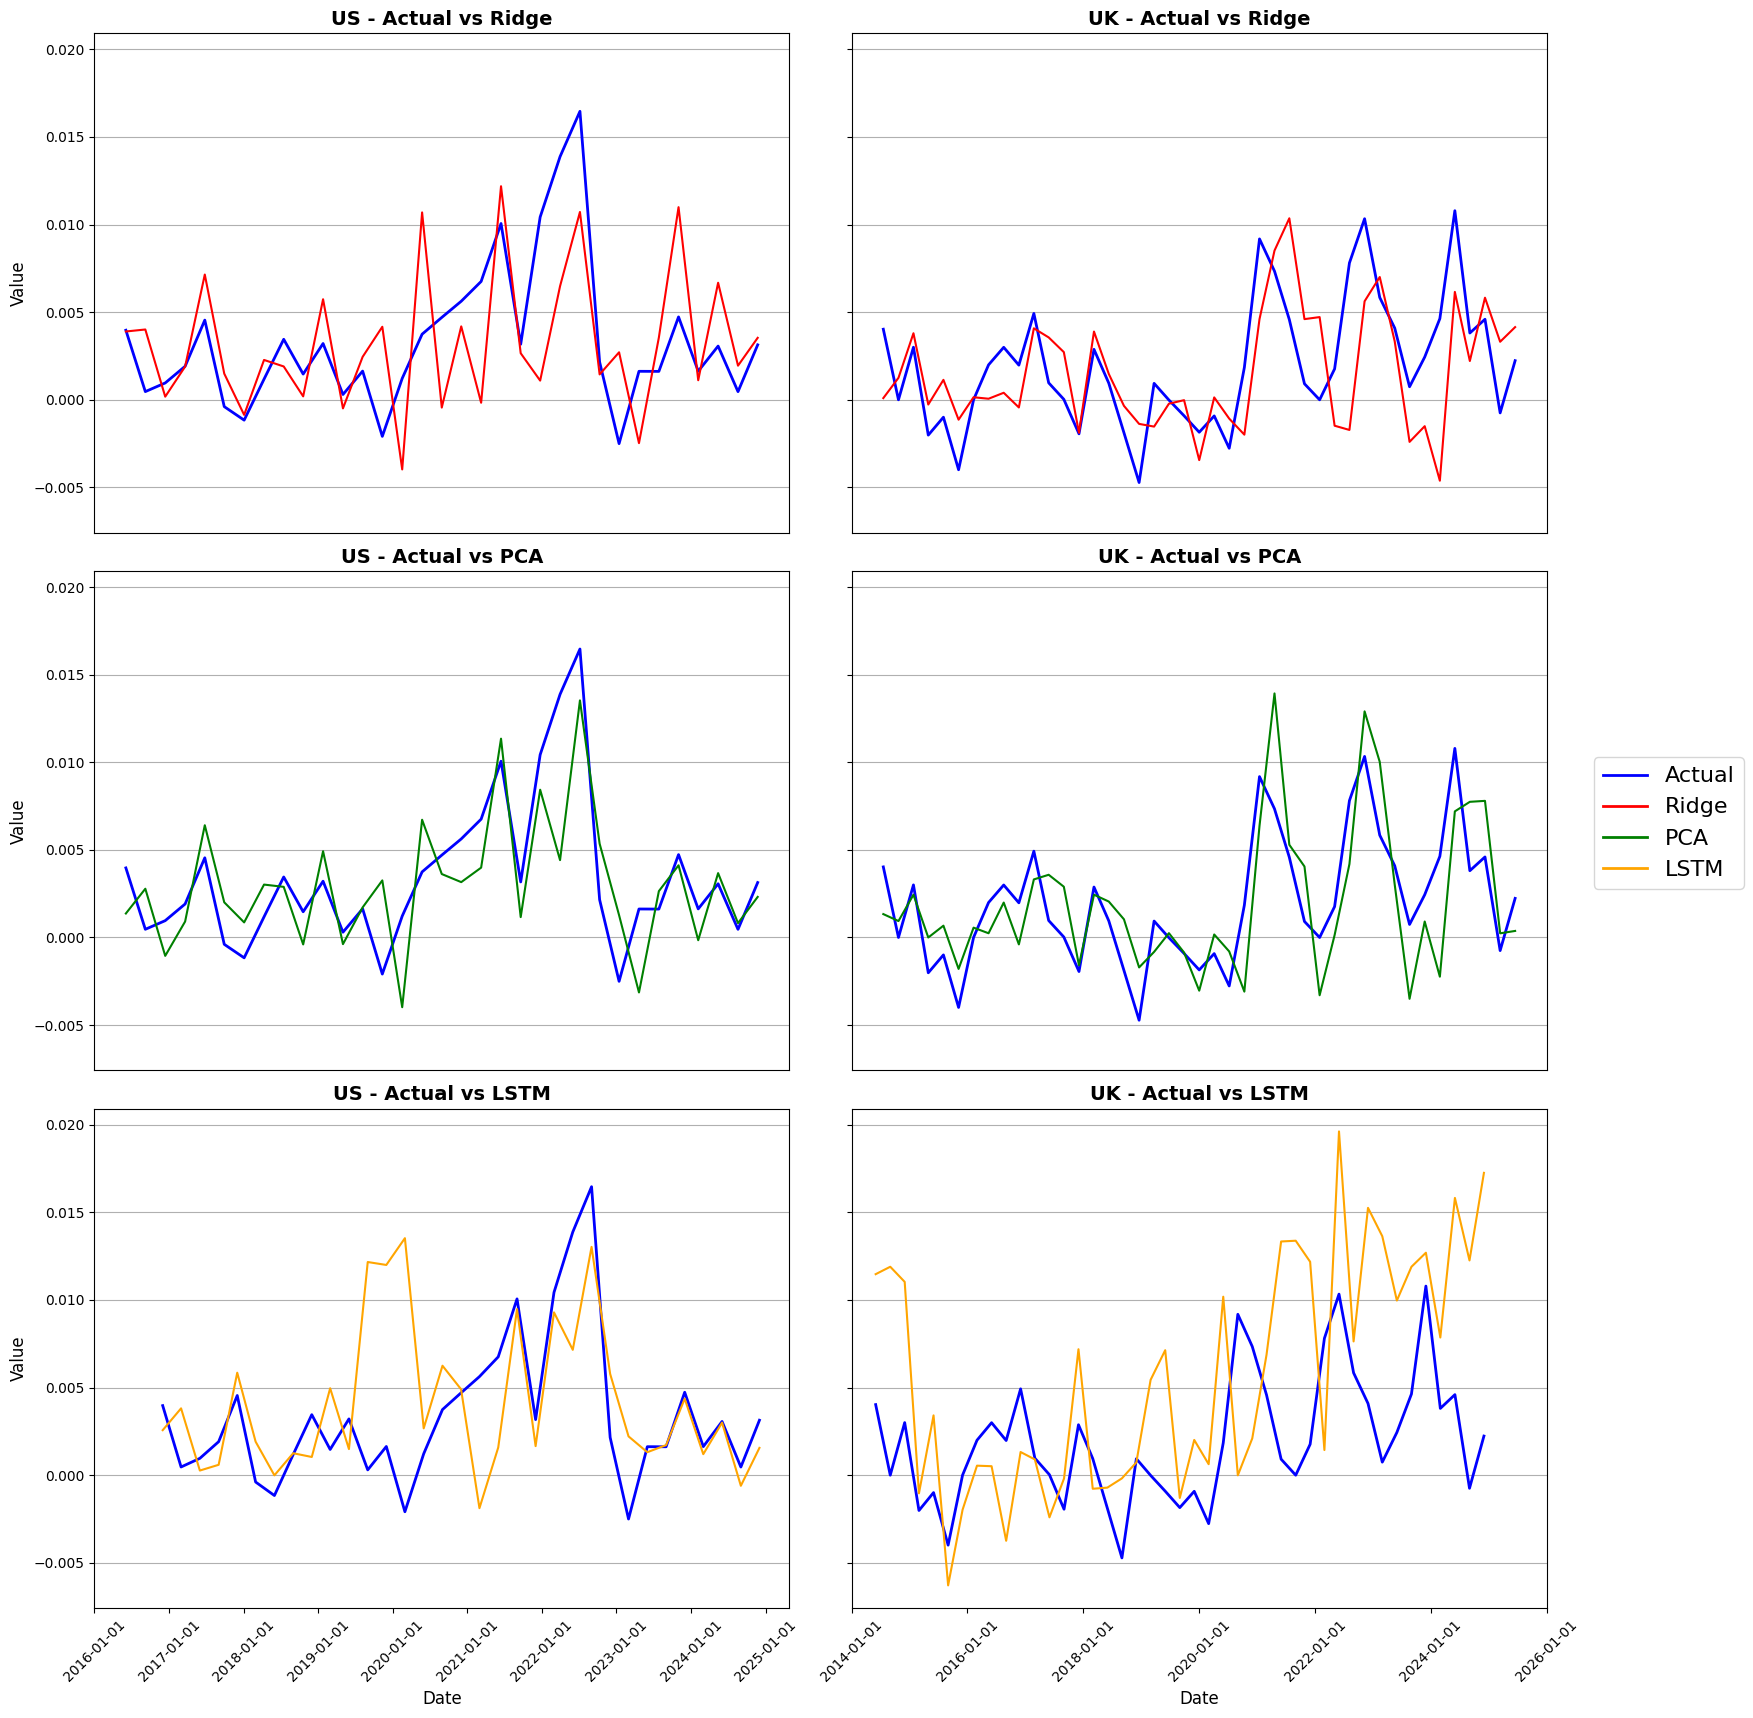

In [6]:
def plot_us_uk_comparison(us_results, uk_results):
    us_results = us_results[us_results['date']>='01-01-2014']
    uk_results = uk_results[uk_results['date']>='06-01-2014']
    # return(uk_results)
    # Create a 3x2 subplot grid (3 rows, 2 columns)
    fig, axs = plt.subplots(3, 2, figsize=(16, 18), sharey='all')

    # Plot US results in the first column
    axs[0, 0].plot(us_results["date"], us_results["actual"], label="Actual", color='blue', linewidth=2)
    axs[0, 0].plot(us_results["date"], us_results["ridge"], label="Ridge", color='red')
    axs[0, 0].set_ylabel("Value", fontsize=12)
    axs[0, 0].set_title("US - Actual vs Ridge", fontsize=14, fontweight = 'bold')
    axs[0, 0].grid(True)  # Add grid
    axs[0, 0].set_xticks([])  # Remove x-ticks
    # axs[0, 0].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))
    
    axs[1, 0].plot(us_results["date"], us_results["actual"], label="Actual", color='blue', linewidth=2)
    axs[1, 0].plot(us_results["date"], us_results["pca"], label="PCA", color='green')
    axs[1, 0].set_ylabel("Value", fontsize=12)
    axs[1, 0].set_title("US - Actual vs PCA", fontsize=14, fontweight = 'bold')
    axs[1, 0].grid(True)  # Add grid
    axs[1, 0].set_xticks([])  # Remove x-ticks
    # axs[1, 0].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))

    axs[2, 0].plot(us_results["date"], us_results["actual"], label="Actual", color='blue', linewidth=2)
    axs[2, 0].plot(us_results["date"], us_results["lstm"], label="LSTM", color='orange')
    axs[2, 0].set_xlabel("Date", fontsize=12)
    axs[2, 0].set_ylabel("Value", fontsize=12)
    axs[2, 0].set_title("US - Actual vs LSTM", fontsize=14, fontweight = 'bold')
    axs[2, 0].grid(True, axis='y')  # Add grid
    # axs[2, 0].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))

    # Plot UK results in the second column
    axs[0, 1].plot(uk_results["date"], uk_results["actual"], label="Actual", color='blue', linewidth=2)
    axs[0, 1].plot(uk_results["date"], uk_results["ridge"], label="Ridge", color='red')
    # axs[0, 1].set_ylabel("Value", fontsize=12)
    axs[0, 1].set_title("UK - Actual vs Ridge", fontsize=14, fontweight = 'bold')
    axs[0, 1].grid(True)  # Add grid
    axs[0, 1].set_xticks([])  # Remove x-ticks
    # axs[0, 1].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))

    axs[1, 1].plot(uk_results["date"], uk_results["actual"], label="Actual", color='blue', linewidth=2)
    axs[1, 1].plot(uk_results["date"], uk_results["pca"], label="PCA", color='green')
    # axs[1, 1].set_ylabel("Value", fontsize=12)
    axs[1, 1].set_title("UK - Actual vs PCA", fontsize=14, fontweight = 'bold')
    axs[1, 1].grid(True)  # Add grid
    axs[1, 1].set_xticks([])  # Remove x-ticks
    # axs[1, 1].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))
    
    axs[2, 1].plot(uk_results["date"], uk_results["actual"], label="Actual", color='blue', linewidth=2)
    axs[2, 1].plot(uk_results["date"], uk_results["lstm"], label="LSTM", color='orange')
    axs[2, 1].set_xlabel("Date", fontsize=12)
    # axs[2, 1].set_ylabel("Value", fontsize=12)
    axs[2, 1].set_title("UK - Actual vs LSTM", fontsize=14, fontweight = 'bold')
    axs[2, 1].grid(True, axis='y')  # Add grid
    axs[2, 1].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))

    # Define a single custom legend for all subplots
    handles = [
        plt.Line2D([0], [0], color='blue', lw=2, label='Actual'),
        plt.Line2D([0], [0], color='red', lw=2, label='Ridge'),
        plt.Line2D([0], [0], color='green', lw=2, label='PCA'),
        plt.Line2D([0], [0], color='orange', lw=2, label='LSTM')
    ]
    labels = ['Actual', 'Ridge', 'PCA', 'LSTM']

    # Add a common legend with the custom handles
    fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1.1, 0.5), fontsize=16)

    # Rotate x-axis labels for all subplots
    for ax in axs.flat:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust title and layout

    # Show plot
    plt.show()

plot_us_uk_comparison(us_results_overall, uk_results_overall)